# Read Merged Fors2, Galex and Kids

The Spectra are shown in Fnu units (maggies)


- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : 2023-06-12
- update : 2023-06-19 (correct for index in spectrum)


From this mergin work on spectra and photometry can start

In [1]:
import h5py
import pandas as pd
import numpy as np
import os
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt

In [2]:
from astropy import units as u
from astropy import constants as const
U_FNU = u.def_unit(u'fnu',  u.erg / (u.cm**2 * u.s * u.Hz))
U_FNU.to(u.Jy)

1e+23

In [3]:
U_FL = u.def_unit(u'fl',  u.erg / (u.cm**2 * u.s * u.AA))

In [4]:
a = 1. * (u.photon / u.s / u.angstrom)
a.to(u.erg / u.s / u.Hz, equivalencies=u.spectral_density(5500 * u.AA))  

<Quantity 3.64433858e-23 erg / (Hz s)>

In [5]:
w = 5000 * u.AA
a = 1. * (u.erg / u.cm**2 / u.s)
b = a.to(u.photon / u.cm**2 / u.s, u.spectral_density(w))
b

<Quantity 2.51705828e+11 ph / (cm2 s)>

In [6]:
([1000, 2000] * u.nm).to(u.Hz, equivalencies=u.spectral())  

<Quantity [2.99792458e+14, 1.49896229e+14] Hz>

In [7]:
# we fix the red wavelength of red for convenient conversion
wl_red = 6231

In [8]:
def GetColumnHfData(hff,list_of_keys,nameval):
    """
    Extract hff atttribute 
    
    parameters
      hff           : descriptor of h5 file
      list_of_keys : list of spectra names
      nameval      : name of the attribute
      
    return
           the array of values in the order of 
    """
    all_data = []
    for key in list_of_keys:
        group=hff.get(key)
        val=group.attrs[nameval]
        all_data.append(val)
    return all_data


In [9]:
def ReadFors2h5FileAttributes(hf):
    hf =  h5py.File(input_file_h5, 'r') 
    list_of_keys = list(hf.keys())
    # pick one key    
    key_sel =  list_of_keys[0]
    # pick one group
    group = hf.get(key_sel)  
    #pickup all attribute names
    all_subgroup_keys = []
    for k in group.attrs.keys():
        all_subgroup_keys.append(k)
        
    print(all_subgroup_keys)
    # create info
    df_info = pd.DataFrame()
    for key in all_subgroup_keys:
        arr=GetColumnHfData(hf, list_of_keys ,key)
        df_info[key] = arr
    df_info.sort_values(by="num", ascending=True,inplace=True)
    df_info_num = df_info["num"].values
    key_tags = [ f"SPEC{num}" for num in df_info_num ]
    df_info["name"] = key_tags
    
    #'Nsp', 'RT', 'RV', 'Rmag', 'dec', 'eRV', 'lines', 'num', 'ra', 'redshift',
    
    #df_info = df_info[['num' ,'name', 'ra', 'dec', 'Rmag','redshift','lines','RT','RV','eRV','Nsp']]
    return df_info

In [10]:
ordered_keys = ['name','num','ra','dec', 'redshift','Rmag','RT', 'RV','eRV','Nsp','lines',
                'ra_galex','dec_galex','fuv_mag', 'fuv_magerr','nuv_mag', 'nuv_magerr', 
                'fuv_flux', 'fuv_fluxerr','nuv_flux', 'nuv_fluxerr','asep_galex',
                'ID', 'KIDS_TILE','RAJ2000','DECJ2000','Z_ML', 'Z_B','asep_kids','CLASS_STAR',
                'MAG_GAAP_u','MAG_GAAP_g','MAG_GAAP_r','MAG_GAAP_i','MAG_GAAP_Z','MAG_GAAP_Y','MAG_GAAP_J', 'MAG_GAAP_H','MAG_GAAP_Ks',
                'MAGERR_GAAP_u','MAGERR_GAAP_g','MAGERR_GAAP_r','MAGERR_GAAP_i','MAGERR_GAAP_Z','MAGERR_GAAP_Y','MAGERR_GAAP_J','MAGERR_GAAP_H','MAGERR_GAAP_Ks',
                'FLUX_GAAP_u','FLUX_GAAP_g','FLUX_GAAP_r','FLUX_GAAP_i','FLUX_GAAP_Z','FLUX_GAAP_Y','FLUX_GAAP_J', 'FLUX_GAAP_H','FLUX_GAAP_Ks',
                'FLUXERR_GAAP_u','FLUXERR_GAAP_g','FLUXERR_GAAP_r','FLUXERR_GAAP_i','FLUXERR_GAAP_Z','FLUXERR_GAAP_Y','FLUXERR_GAAP_J','FLUXERR_GAAP_H','FLUXERR_GAAP_Ks',
                'FLUX_RADIUS', 'EXTINCTION_u','EXTINCTION_g','EXTINCTION_r', 'EXTINCTION_i',]
                

In [11]:
def ConvertFlambda_to_Fnu(wl, flambda):
    """
    Convert spectra density flambda to fnu.
    parameters:
        - Flambda : flux density in erg/s/cm2 /AA or W/cm2/AA

    return
         - Fnu : flux density in erg/s/cm2/Hz or W/cm2/Hz


    Compute Fnu = wl**2/c Flambda
    check the conversion units with astropy units and constants 
    
    """
    
    fnu = (flambda*U_FL*(wl*u.AA)**2/const.c).to(U_FNU)/(1*U_FNU)
    #fnu = (flambda* (u.erg / (u.cm**2 * u.s * u.AA)) *(wl*u.AA)**2/const.c).to( u.erg / (u.cm**2 * u.s * u.Hz))/(u.erg / (u.cm**2 * u.s * u.Hz))
    
    return fnu
 

In [12]:
ConvertFlambda_to_Fnu(1, 1)

<Quantity 3.33564095e-19>

In [13]:
lambda_red = 6231
lambda_width = 50
lambda_sel_min = lambda_red-lambda_width /2.
lambda_sel_max = lambda_red+lambda_width /2.

In [14]:
def flux_norm(wl,fl):
    idx_wl_sel = np.where(np.logical_and(wl>= lambda_sel_min,wl<= lambda_sel_max))[0]
    flarr_norm = fl[idx_wl_sel]
    return np.median(flarr_norm)

# Read Fors2 / Galex and Kids

In [15]:
input_file_h5  = '../data/FORS2spectraGalexKidsPhotom.hdf5'

In [16]:
hf =  h5py.File(input_file_h5, 'r') 
list_of_keys = list(hf.keys())

In [17]:
df_info = ReadFors2h5FileAttributes(hf)

['CLASS_STAR', 'DECJ2000', 'EXTINCTION_g', 'EXTINCTION_i', 'EXTINCTION_r', 'EXTINCTION_u', 'FLUXERR_GAAP_H', 'FLUXERR_GAAP_J', 'FLUXERR_GAAP_Ks', 'FLUXERR_GAAP_Y', 'FLUXERR_GAAP_Z', 'FLUXERR_GAAP_g', 'FLUXERR_GAAP_i', 'FLUXERR_GAAP_r', 'FLUXERR_GAAP_u', 'FLUX_GAAP_H', 'FLUX_GAAP_J', 'FLUX_GAAP_Ks', 'FLUX_GAAP_Y', 'FLUX_GAAP_Z', 'FLUX_GAAP_g', 'FLUX_GAAP_i', 'FLUX_GAAP_r', 'FLUX_GAAP_u', 'FLUX_RADIUS', 'ID', 'KIDS_TILE', 'MAGERR_GAAP_H', 'MAGERR_GAAP_J', 'MAGERR_GAAP_Ks', 'MAGERR_GAAP_Y', 'MAGERR_GAAP_Z', 'MAGERR_GAAP_g', 'MAGERR_GAAP_i', 'MAGERR_GAAP_r', 'MAGERR_GAAP_u', 'MAG_GAAP_H', 'MAG_GAAP_J', 'MAG_GAAP_Ks', 'MAG_GAAP_Y', 'MAG_GAAP_Z', 'MAG_GAAP_g', 'MAG_GAAP_i', 'MAG_GAAP_r', 'MAG_GAAP_u', 'Nsp', 'RAJ2000', 'RT', 'RV', 'Rmag', 'Z_B', 'Z_ML', 'asep_galex', 'asep_kids', 'dec', 'dec_galex', 'eRV', 'fuv_flux', 'fuv_fluxerr', 'fuv_mag', 'fuv_magerr', 'lines', 'name', 'num', 'nuv_flux', 'nuv_fluxerr', 'nuv_mag', 'nuv_magerr', 'ra', 'ra_galex', 'redshift']


In [18]:
df_info.reset_index(drop=True, inplace=True) 

In [19]:
df_info = df_info[ordered_keys]

### Get Spectra

In [20]:
df_info_num = df_info["num"].values
key_tags = [ f"SPEC{num}" for num in df_info_num ]

In [21]:
all_df = []   
idx=0
for key in key_tags :
    group = hf.get(key)
    df = pd.DataFrame()
    df["wl"] = np.array(group.get("wl"))
    df["fl"] = np.array(group.get("fl")) 
    all_df.append(df)
    idx+=1

In [22]:
df = df_info

In [23]:
df

name  num        ra       dec  redshift   Rmag    RT      RV  eRV  \
0      SPEC2    2  13.52997 -28.44776   0.34555  21.18  12.3  103665   40   
1      SPEC3    3  13.52552 -28.42080   0.68660  21.45  11.6  210642   48   
2      SPEC9    9  13.50219 -28.40641   0.29266  21.60  13.1   87798   58   
3     SPEC13   13  13.49261 -28.38272   0.68870  23.14   0.0  206610    0   
4     SPEC19   19  13.60758 -28.43452   0.48395  21.70   7.1  145185  104   
..       ...  ...       ...       ...       ...    ...   ...     ...  ...   
545  SPEC734  734  13.68083 -28.23290   0.23012   0.00   7.2   69036   71   
546  SPEC735  735  13.69958 -28.23161   0.36169  19.28   8.2  108507  107   
547  SPEC736  736  13.66431 -28.22849   0.55777  21.64  10.5  167331   31   
548  SPEC737  737  13.62722 -28.22692   0.52001  21.40  10.2  156003   53   
549  SPEC738  738  13.64370 -28.22527   0.56044  19.73   7.1  168132  126   

     Nsp  ... FLUXERR_GAAP_Z  FLUXERR_GAAP_Y  FLUXERR_GAAP_J  FLUXERR_GAAP_H  \
0      1  ...     179.816220      356.027740      290.613160      594.538760   
1      4  ...     179.913452      352.837769      287.987885      588.559448   
2      1  ...     185.288483      330.740845      268.486725      579.864075   
3      1  ...     180.381531      323.638702      260.288177             NaN   
4      1  ...     123.689148      238.951889      225.177338      544.024658   
..   ...  ...            ...             ...             ...             ...   
545    1  ...      98.486717      243.505157      196.822708      461.214691   
546    1  ...     102.504509      254.145142      206.989441      479.774139   
547    1  ...     108.492714      222.538773      185.683838      429.756744   
548    1  ...     105.423523      216.082657      179.259644      419.079620   
549    1  ...     115.408852      236.715820      229.090759      464.924103   

     FLUXERR_GAAP_Ks  FLUX_RADIUS  EXTINCTION_u  EXTINCTION_g  EXTINCTION_r  \
0         694.397200     2.967994      0.072517      0.056505      0.039090   
1         685.337463     3.020974      0.075065      0.058490      0.040463   
2         606.197693     2.671784      0.074299      0.057893      0.040050   
3                NaN     2.192928      0.077572      0.060444      0.041815   
4         507.931976     2.992076      0.075642      0.058940      0.040774   
..               ...          ...           ...           ...           ...   
545       495.400299     3.462931      0.073033      0.056906      0.039368   
546       521.821655     3.587435      0.072326      0.056356      0.038987   
547       456.459747     4.769248      0.074087      0.057728      0.039936   
548       434.556122     2.864109      0.079347      0.061827      0.042772   
549       490.705872     7.467356      0.078741      0.061355      0.042445   

     EXTINCTION_i  
0        0.029048  
1        0.030069  
2        0.029762  
3        0.031073  
4        0.030300  
..            ...  
545      0.029254  
546      0.028971  
547      0.029677  
548      0.031784  
549      0.031541  

[550 rows x 71 columns]

# Select good match with galex

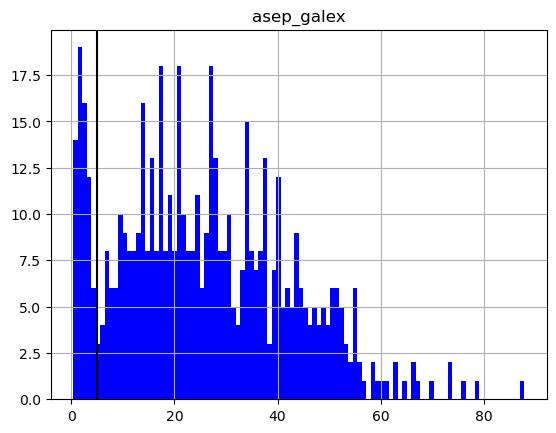

In [24]:
df.hist("asep_galex",bins=100,color="b")
plt.axvline(5,c="k")

array([[<Axes: title={'center': 'asep_kids'}>]], dtype=object)

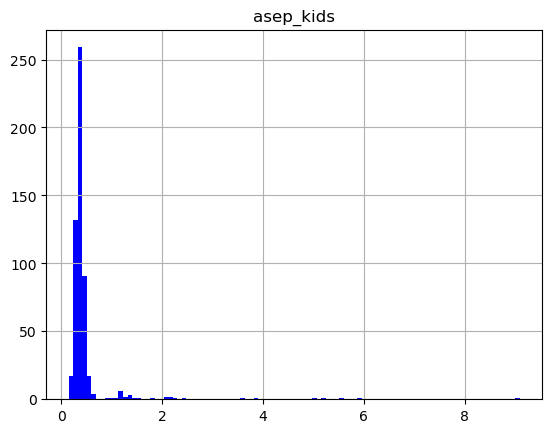

In [25]:
df.hist("asep_kids",bins=100,color='b')

## Select  Those spectra having GALEX

In [26]:
df = df[df["asep_galex"] <= 5]

## reindex

In [27]:
df['index0'] = df.index
df = df.reset_index()

/var/folders/cq/vms8st5136z3q5xx4rd9xqfr0000gw/T/ipykernel_13323/1867917747.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['index0'] = df.index


## Remove NaN

- remove those row with no FUV

In [28]:
#df = df.dropna()

## Remove rows with Rmag = 0

In [29]:
#df = df[df["Rmag"] > 0]

In [30]:
df.columns

Index(['index', 'name', 'num', 'ra', 'dec', 'redshift', 'Rmag', 'RT', 'RV',
       'eRV', 'Nsp', 'lines', 'ra_galex', 'dec_galex', 'fuv_mag', 'fuv_magerr',
       'nuv_mag', 'nuv_magerr', 'fuv_flux', 'fuv_fluxerr', 'nuv_flux',
       'nuv_fluxerr', 'asep_galex', 'ID', 'KIDS_TILE', 'RAJ2000', 'DECJ2000',
       'Z_ML', 'Z_B', 'asep_kids', 'CLASS_STAR', 'MAG_GAAP_u', 'MAG_GAAP_g',
       'MAG_GAAP_r', 'MAG_GAAP_i', 'MAG_GAAP_Z', 'MAG_GAAP_Y', 'MAG_GAAP_J',
       'MAG_GAAP_H', 'MAG_GAAP_Ks', 'MAGERR_GAAP_u', 'MAGERR_GAAP_g',
       'MAGERR_GAAP_r', 'MAGERR_GAAP_i', 'MAGERR_GAAP_Z', 'MAGERR_GAAP_Y',
       'MAGERR_GAAP_J', 'MAGERR_GAAP_H', 'MAGERR_GAAP_Ks', 'FLUX_GAAP_u',
       'FLUX_GAAP_g', 'FLUX_GAAP_r', 'FLUX_GAAP_i', 'FLUX_GAAP_Z',
       'FLUX_GAAP_Y', 'FLUX_GAAP_J', 'FLUX_GAAP_H', 'FLUX_GAAP_Ks',
       'FLUXERR_GAAP_u', 'FLUXERR_GAAP_g', 'FLUXERR_GAAP_r', 'FLUXERR_GAAP_i',
       'FLUXERR_GAAP_Z', 'FLUXERR_GAAP_Y', 'FLUXERR_GAAP_J', 'FLUXERR_GAAP_H',
       'FLUXERR_GAAP_Ks', 'FL

# Plot Spectra

https://en.wikipedia.org/wiki/Photometric_system

In [31]:
lambda_FUV = 1528.
lambda_NUV = 2271.
lambda_U = 3650.
lambda_B = 4450.
lambda_G = 4640.
lambda_R = 5580.
lambda_I = 8060.
lambda_Z = 9000.
lambda_Y = 10200.
lambda_J = 12200.
lambda_H = 16300.
lambda_K = 21900.
lambda_L = 34500.

WL = [lambda_FUV, lambda_NUV, lambda_B, lambda_G, lambda_R ,lambda_I, lambda_Z, lambda_Y, lambda_J, lambda_H, lambda_K ]

In [32]:
df

index     name  num        ra       dec  redshift   Rmag    RT      RV  \
0      13   SPEC36   36  13.56870 -28.43129   0.82266  19.96  13.0  246798   
1      38   SPEC85   85  13.53755 -28.38375   0.97900  23.21   0.0       0   
2      70  SPEC151  151  13.54459 -28.38795   0.49762  22.23  11.1  149286   
3      98  SPEC214  214  13.54850 -28.42296   0.29266  19.80  16.1   87798   
4      99  SPEC218  218  13.54348 -28.43490   0.43800  21.27   0.0  131400   
..    ...      ...  ...       ...       ...       ...    ...   ...     ...   
63    533  SPEC722  722  13.69932 -28.26123   1.21050  20.99  17.5  363150   
64    535  SPEC724  724  13.66411 -28.25705   0.23168  21.07  13.5   69504   
65    536  SPEC725  725  13.69168 -28.25586   0.23010  20.86  14.1   69030   
66    538  SPEC727  727  13.69381 -28.25005   0.23060  22.59   5.9   69180   
67    543  SPEC732  732  13.71984 -28.23666   0.16176  19.24  19.9   48526   

    eRV  ...  FLUXERR_GAAP_Y FLUXERR_GAAP_J  FLUXERR_GAAP_H  FLUXERR_GAAP_Ks  \
0    80  ...      340.098511     277.472107      570.941833       660.577942   
1     0  ...      323.638702     260.301910      556.272217       609.571655   
2    33  ...      332.456512     269.498627      576.139160       628.552673   
3    23  ...      348.236633     284.142151      584.317017       679.517578   
4     0  ...      375.119659     309.391968      636.975586       740.847229   
..  ...  ...             ...            ...             ...              ...   
63  234  ...      253.777481     205.343628      464.147339       514.735779   
64   36  ...      242.339783     191.391754      440.170135       480.001190   
65   29  ...      252.362854     204.230362      465.261749       512.764404   
66   81  ...      261.258026     214.011581      488.609253       536.854980   
67   18  ...      271.876343     224.781738      511.921875       565.901917   

    FLUX_RADIUS  EXTINCTION_u  EXTINCTION_g  EXTINCTION_r  EXTINCTION_i  \
0      4.946754      0.075650      0.058946      0.040779      0.030303   
1      1.904666      0.080195      0.062487      0.043228      0.032123   
2      3.000832      0.080068      0.062388      0.043160      0.032072   
3      4.766320      0.076636      0.059715      0.041310      0.030698   
4      4.821135      0.073811      0.057513      0.039787      0.029566   
..          ...           ...           ...           ...           ...   
63     2.023525      0.071443      0.055668      0.038511      0.028618   
64     3.872675      0.070691      0.055082      0.038105      0.028316   
65     4.971230      0.071652      0.055831      0.038623      0.028701   
66     3.747046      0.070389      0.054846      0.037942      0.028195   
67     4.654228      0.071652      0.055831      0.038624      0.028701   

    index0  
0       13  
1       38  
2       70  
3       98  
4       99  
..     ...  
63     533  
64     535  
65     536  
66     538  
67     543  

[68 rows x 73 columns]

In [33]:
df.columns

Index(['index', 'name', 'num', 'ra', 'dec', 'redshift', 'Rmag', 'RT', 'RV',
       'eRV', 'Nsp', 'lines', 'ra_galex', 'dec_galex', 'fuv_mag', 'fuv_magerr',
       'nuv_mag', 'nuv_magerr', 'fuv_flux', 'fuv_fluxerr', 'nuv_flux',
       'nuv_fluxerr', 'asep_galex', 'ID', 'KIDS_TILE', 'RAJ2000', 'DECJ2000',
       'Z_ML', 'Z_B', 'asep_kids', 'CLASS_STAR', 'MAG_GAAP_u', 'MAG_GAAP_g',
       'MAG_GAAP_r', 'MAG_GAAP_i', 'MAG_GAAP_Z', 'MAG_GAAP_Y', 'MAG_GAAP_J',
       'MAG_GAAP_H', 'MAG_GAAP_Ks', 'MAGERR_GAAP_u', 'MAGERR_GAAP_g',
       'MAGERR_GAAP_r', 'MAGERR_GAAP_i', 'MAGERR_GAAP_Z', 'MAGERR_GAAP_Y',
       'MAGERR_GAAP_J', 'MAGERR_GAAP_H', 'MAGERR_GAAP_Ks', 'FLUX_GAAP_u',
       'FLUX_GAAP_g', 'FLUX_GAAP_r', 'FLUX_GAAP_i', 'FLUX_GAAP_Z',
       'FLUX_GAAP_Y', 'FLUX_GAAP_J', 'FLUX_GAAP_H', 'FLUX_GAAP_Ks',
       'FLUXERR_GAAP_u', 'FLUXERR_GAAP_g', 'FLUXERR_GAAP_r', 'FLUXERR_GAAP_i',
       'FLUXERR_GAAP_Z', 'FLUXERR_GAAP_Y', 'FLUXERR_GAAP_J', 'FLUXERR_GAAP_H',
       'FLUXERR_GAAP_Ks', 'FL

# Plot

## Plot Magnitude correlation

In [34]:
df_rmag = df[df["Rmag"] > 0]

<Axes: title={'center': 'Kids R magnitude vs Fors2 R Petrosian magnitude'}, xlabel='Rmag', ylabel='MAG_GAAP_r'>

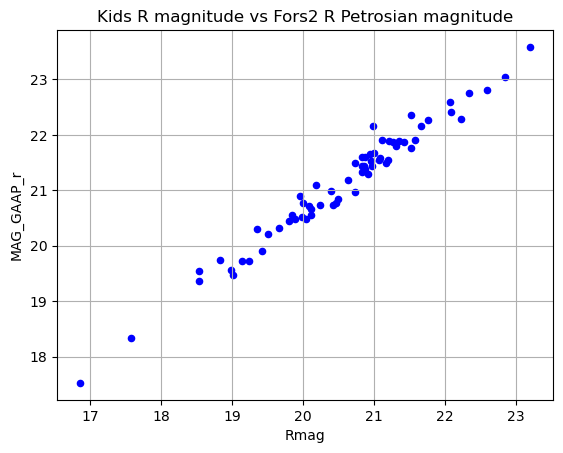

In [35]:
df_rmag.plot.scatter(x="Rmag",y="MAG_GAAP_r",color="b",title="Kids R magnitude vs Fors2 R Petrosian magnitude",grid=True)

# Plots

0  ==  SPEC36 36 13
b'[OII],H9,H8,K,H{beta},[OIII]                                                \r'
2.8383762647730983e-08 3.1398476019576083e-08 3.4538323621533694e-08


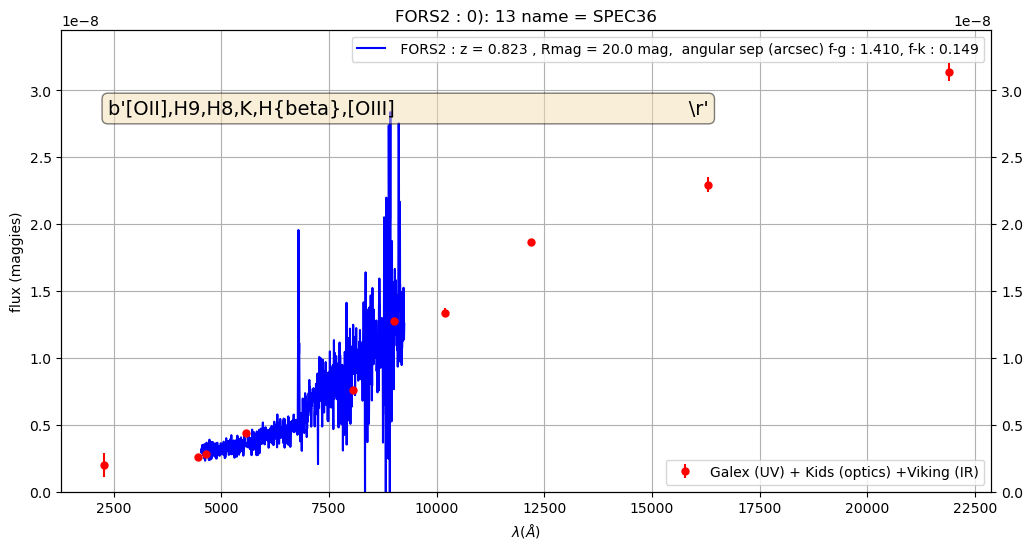

1  ==  SPEC85 85 38
b'MgII,[OII],H                                                                \r'
2.7846990705260144e-09 2.212918196786127e-09 3.063168977578616e-09


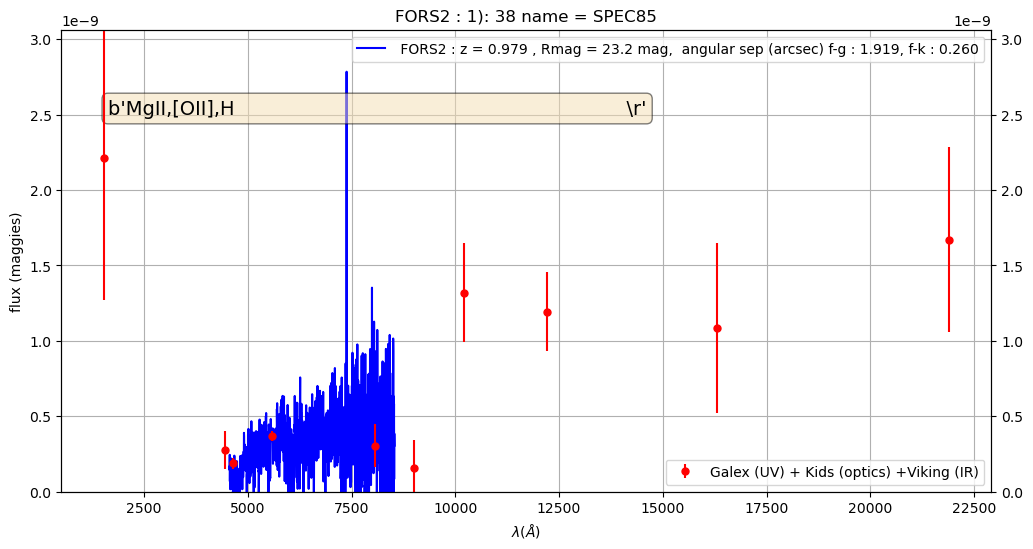

2  ==  SPEC151 151 70
b'[OII],K,H,H{beta}                                                           \r'
1.4877221293551498e-08 3.6440832279519684e-09 1.636494342290665e-08


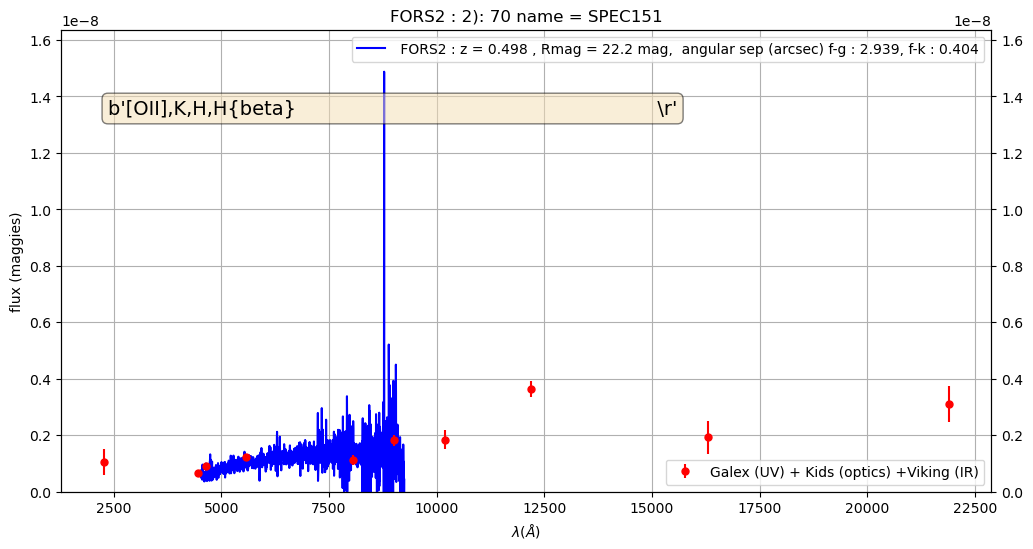

3  ==  SPEC214 214 98
b'[OII],H10,H9,H8,K,H,H{beta},[OIII]                                          \r'
6.502023160340127e-08 2.1600143407326786e-08 7.152225476374141e-08


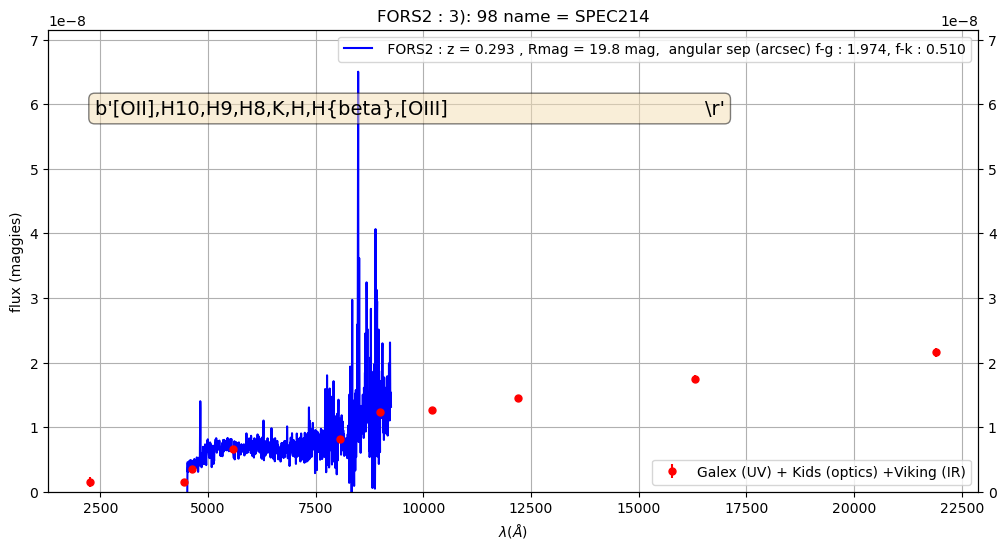

4  ==  SPEC218 218 99
b'[OII]                                                                       \r'
3.7270493305929037e-06 5.165784579276229e-09 4.099754263652194e-06


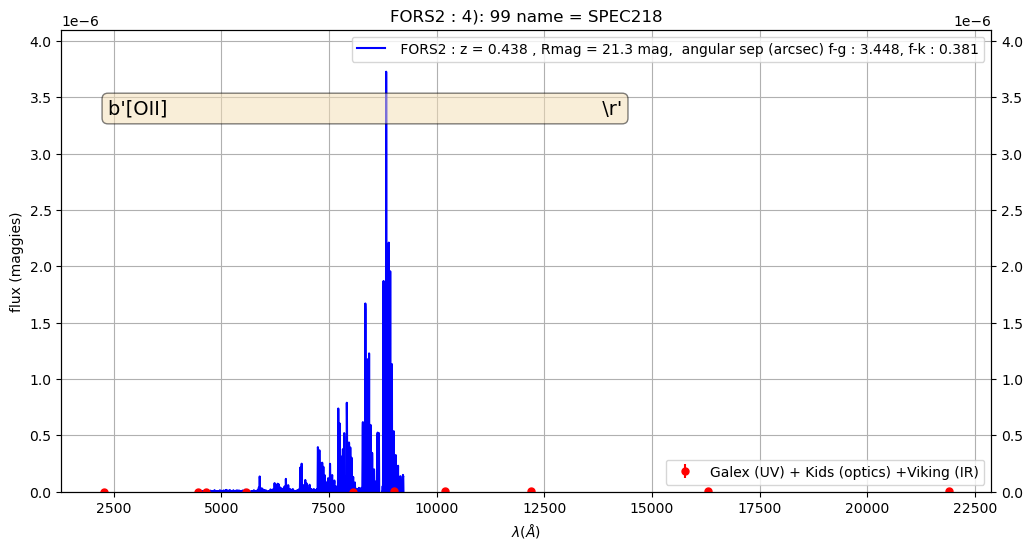

5  ==  SPEC242 242 113
b'[OIII],H{alpha}                                                             \r'
5.543941980358892e-08 2.30510511734554e-08 6.098336178394782e-08


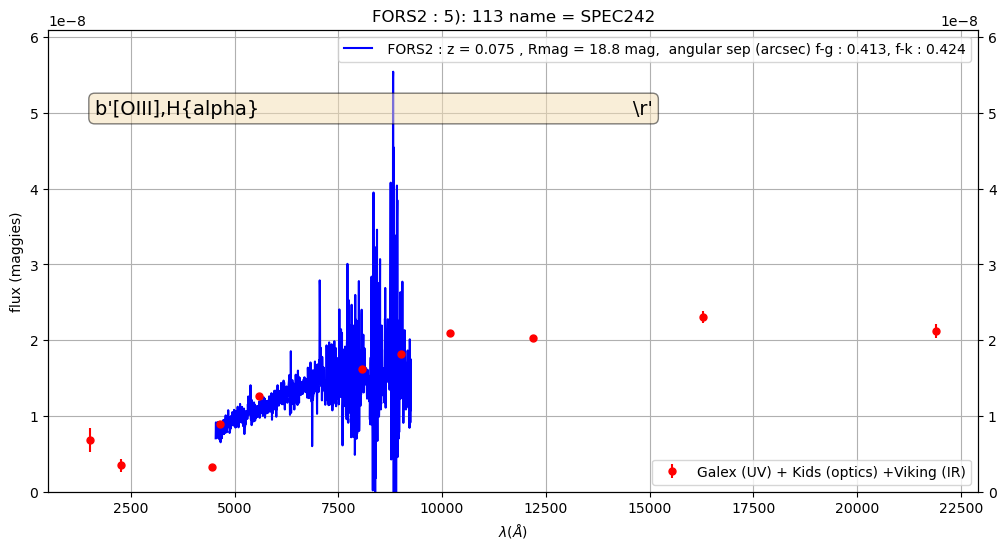

6  ==  SPEC306 306 158
b'MgII,[OII],H10,H9,K                                                         \r'
8.455050161312076e-09 1.2460209950538164e-08 1.3706230945591981e-08


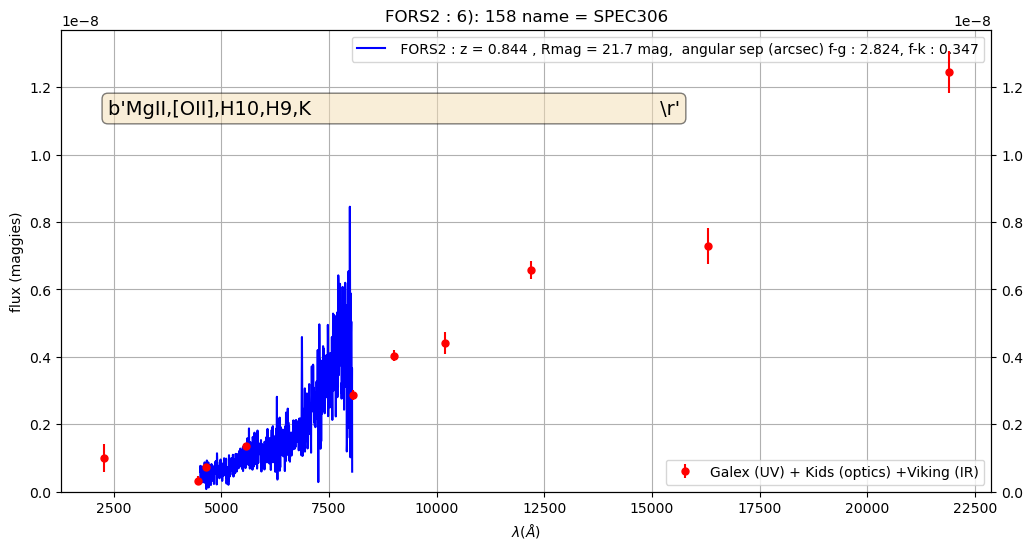

7  ==  SPEC307 307 159
b'[OII],H{alpha}                                                              \r'
5.54911432528049e-09 2.878740883821401e-09 6.104025757808539e-09


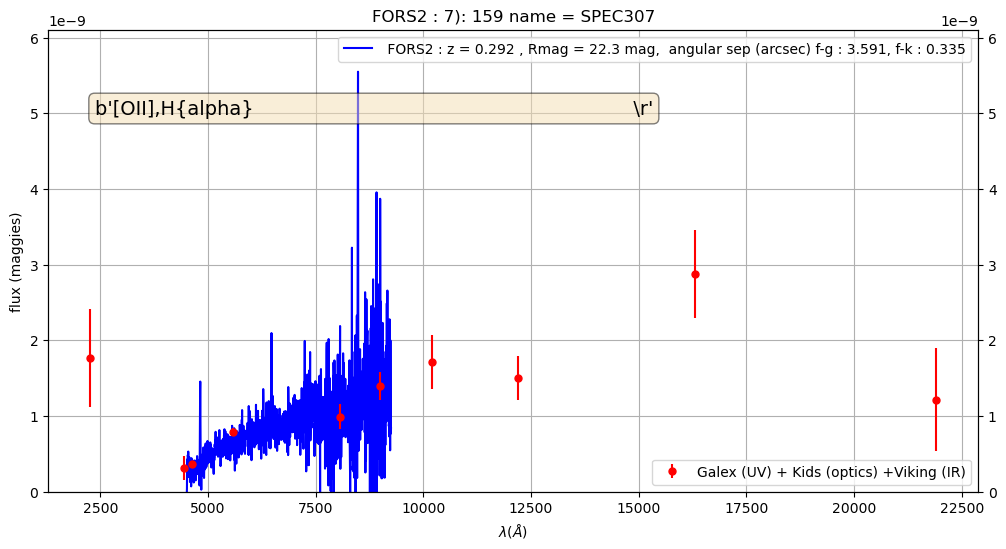

8  ==  SPEC315 315 163
b'[OII],H{beta}                                                               \r'
3.237026680665721e-09 2.506887395074173e-09 3.5607293487322938e-09


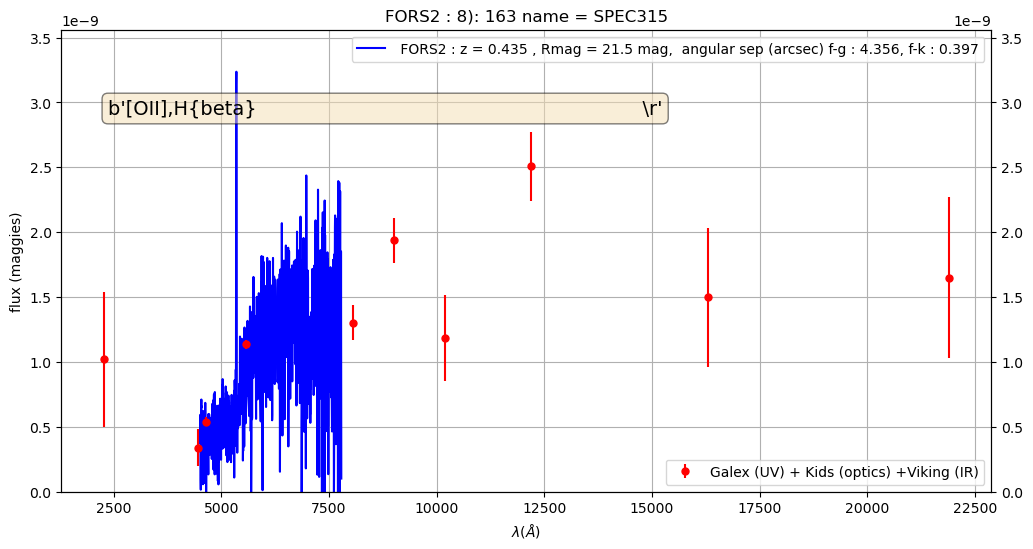

9  ==  SPEC325 325 171
b'[OII],H10,H9,H8,H,H{delta},H{beta},[OIII],H{alpha}                          \r'
6.694463944235078e-08 1.3301920170688033e-08 7.363910338658586e-08


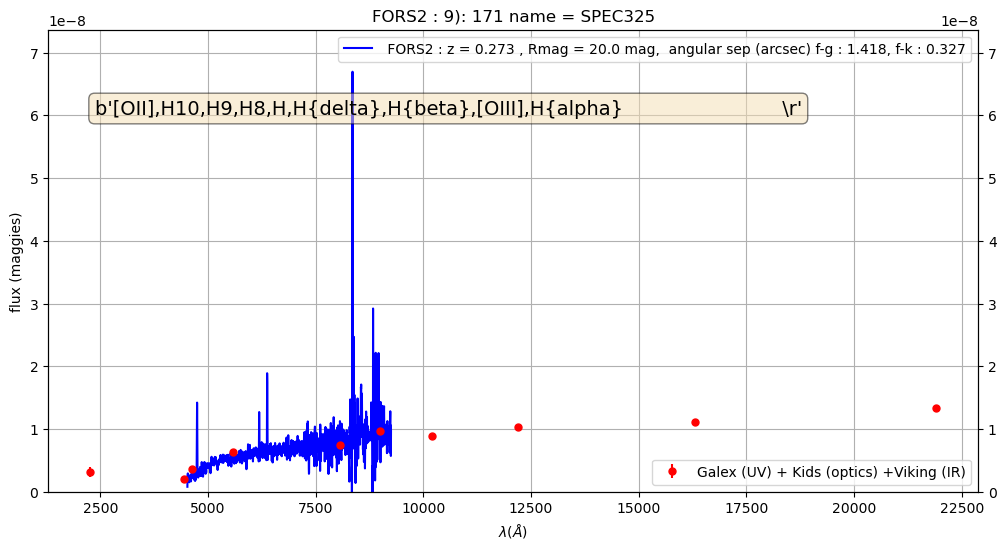

10  ==  SPEC326 326 172
b'[OII],H9,K,H,[OIII],H{alpha}                                                \r'
1.54356494738077e-08 5.294492169235913e-09 1.697921442118847e-08


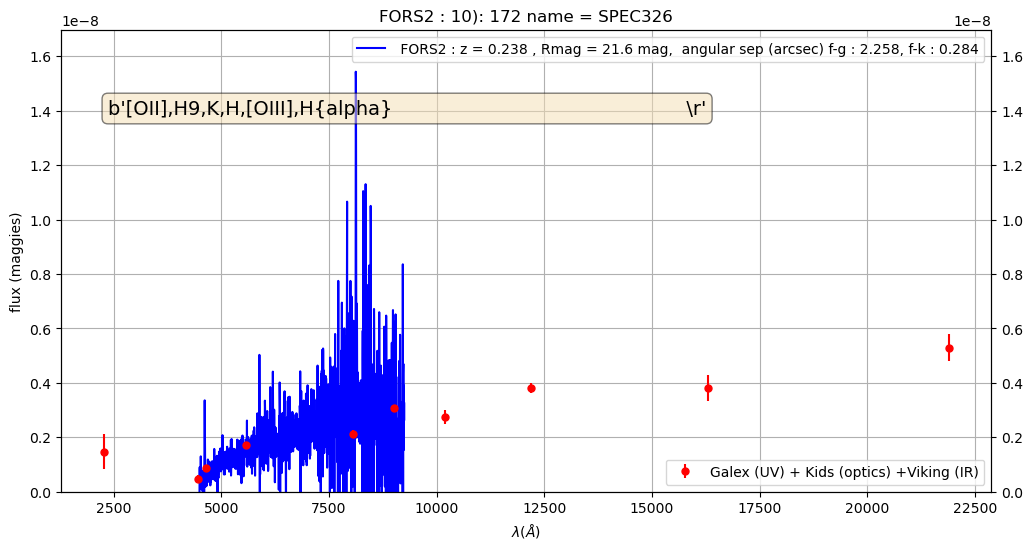

11  ==  SPEC337 337 182
b'[OII],H                                                                     \r'
1.4175038101874924e-08 5.129576156024516e-09 1.5592541912062418e-08


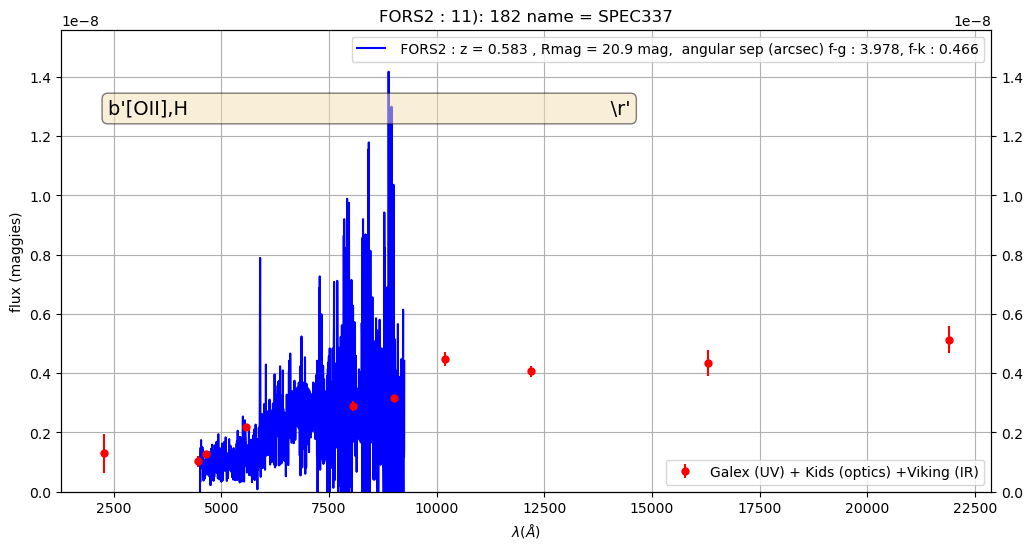

12  ==  SPEC350 350 193
b'[OII],H{beta},[OIII]                                                        \r'
3.930050778336239e-08 3.4685942787722948e-09 4.323055856169863e-08


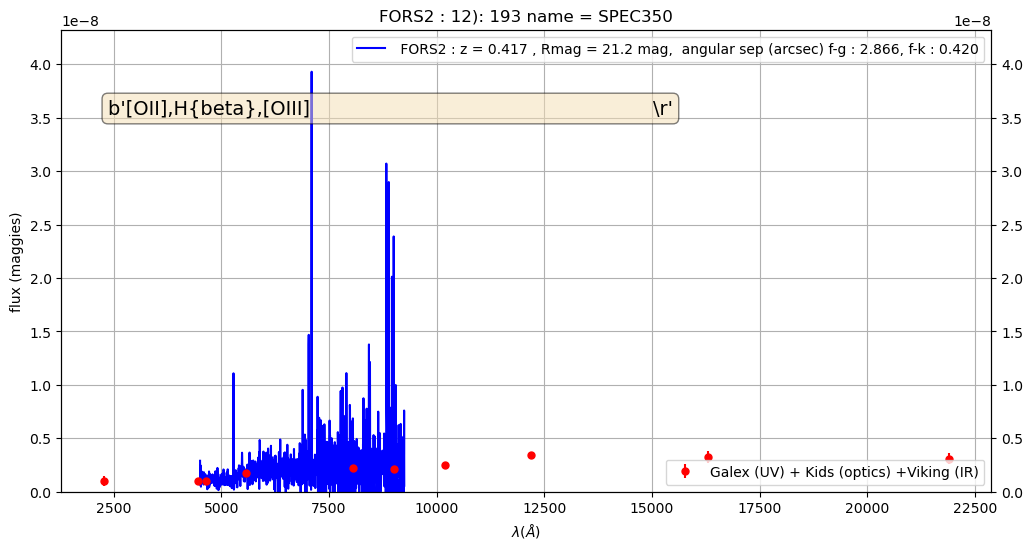

13  ==  SPEC363 363 205
b'H9,H8,H,H{delta},[OIII],H{alpha}                                            \r'
2.0484043584136073e-08 8.094985869114902e-09 2.2532447942549683e-08


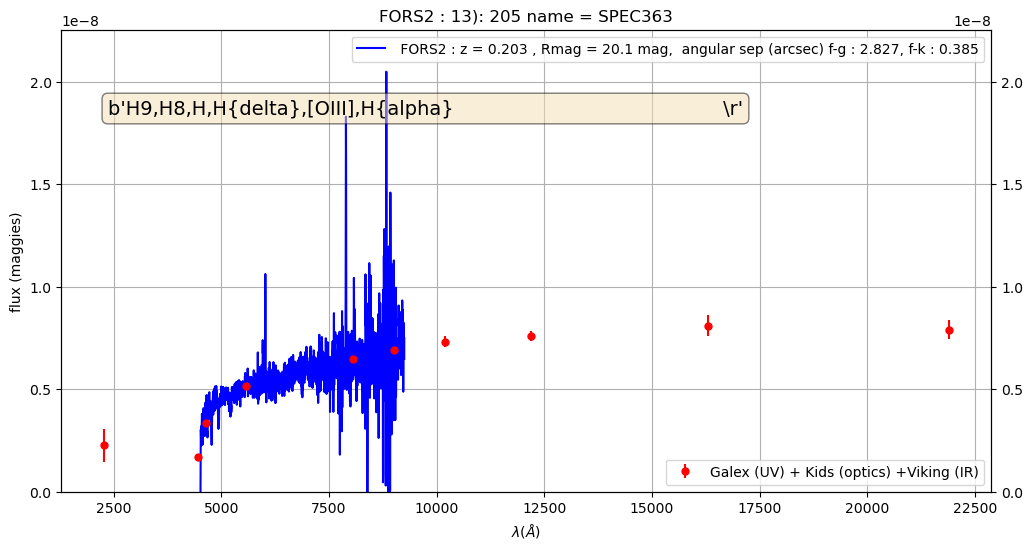

14  ==  SPEC368 368 210
b'[OII],H{delta},H{beta},[OIII]                                               \r'
9.977716987263621e-09 6.146096795924773e-09 1.0975488685989985e-08


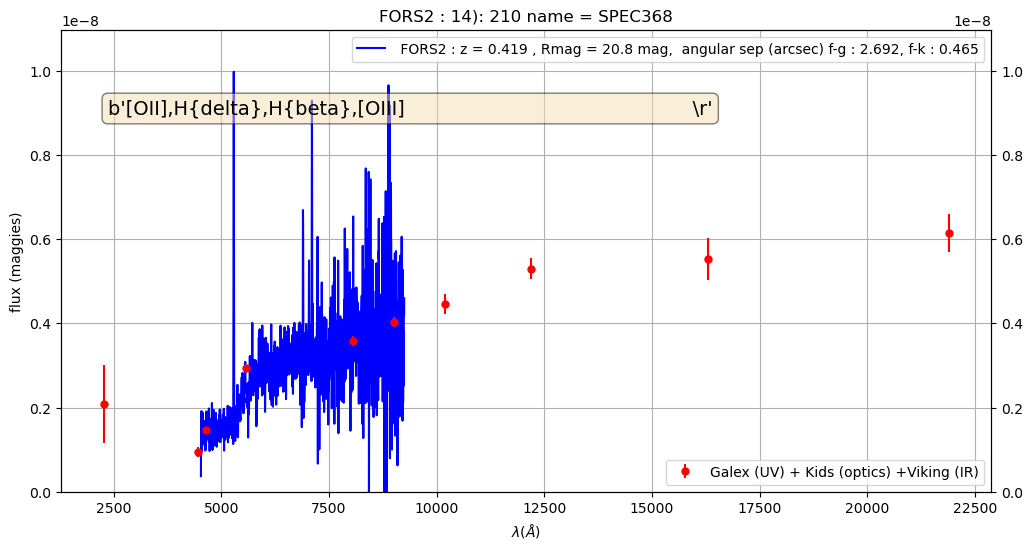

15  ==  SPEC373 373 215
b'[OII],H9,K,H,H{beta},[OIII],H{alpha}                                        \r'
7.487109950652112e-08 9.8925598243637e-09 8.235820945717324e-08


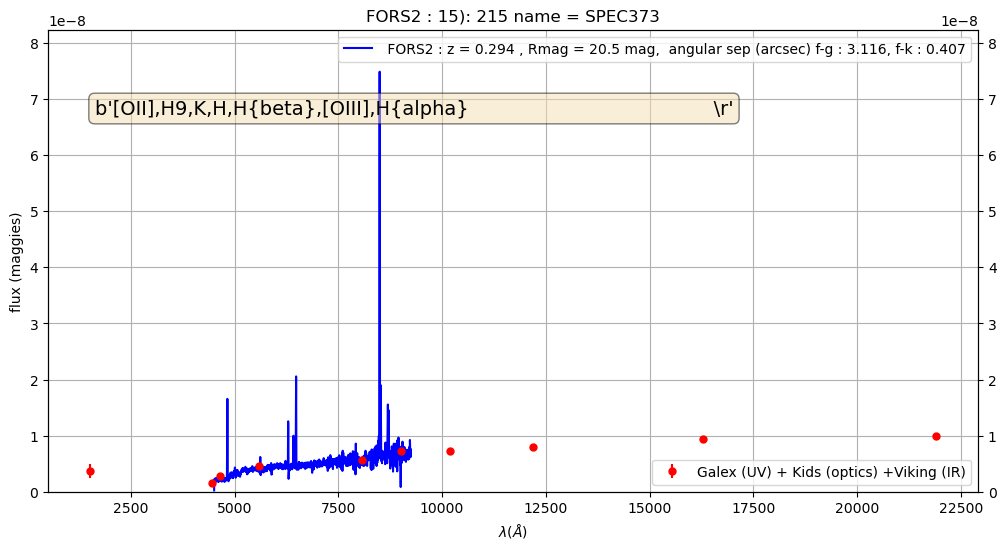

16  ==  SPEC386 386 228
b'[OII],H,H{delta}                                                            \r'
1.5466544671064985e-08 1.2198166462343042e-08 1.7013199138171484e-08


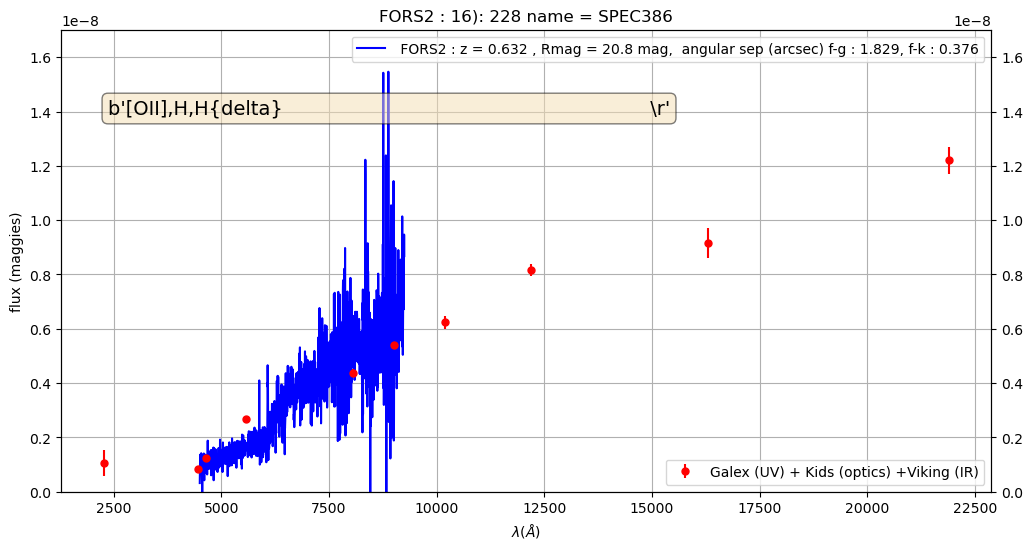

17  ==  SPEC390 390 232
b'[OII],H,H{beta},[OIII]                                                      \r'
8.854586642358519e-09 1.0458170527002173e-08 1.1503987579702392e-08


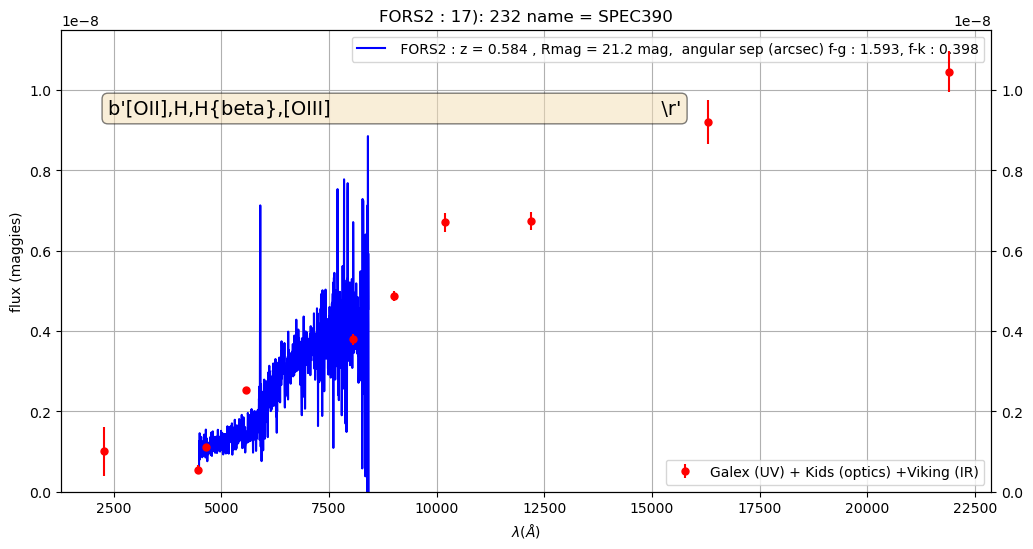

18  ==  SPEC399 399 241
b'[OII],H{gamma},H{beta},[OIII],H{alpha}                                      \r'
5.5709077755345615e-08 6.810148556226456e-09 6.127998553088018e-08


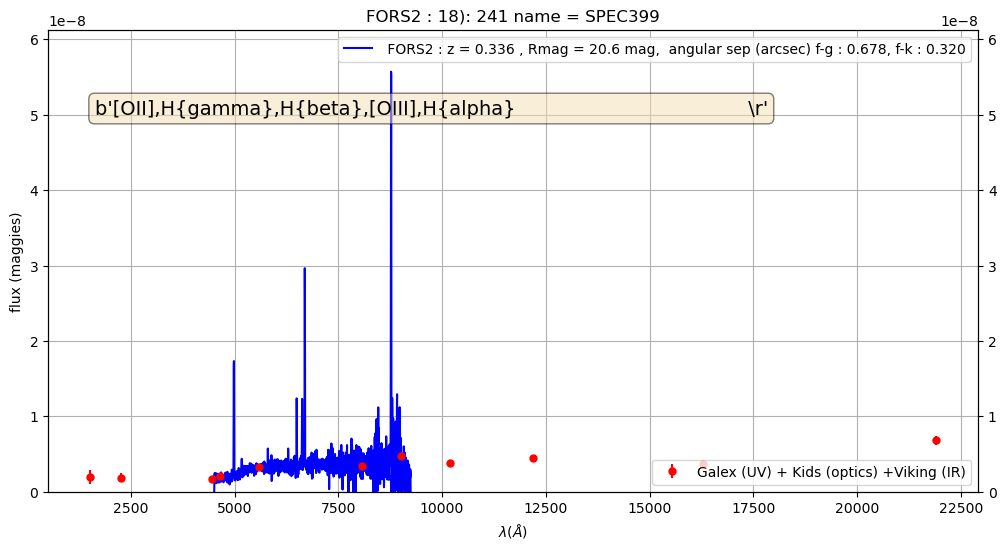

19  ==  SPEC401 401 243
b'[OII],H,H{beta}                                                             \r'
1.5280945679909186e-08 9.525051666524691e-09 1.6809040247900105e-08


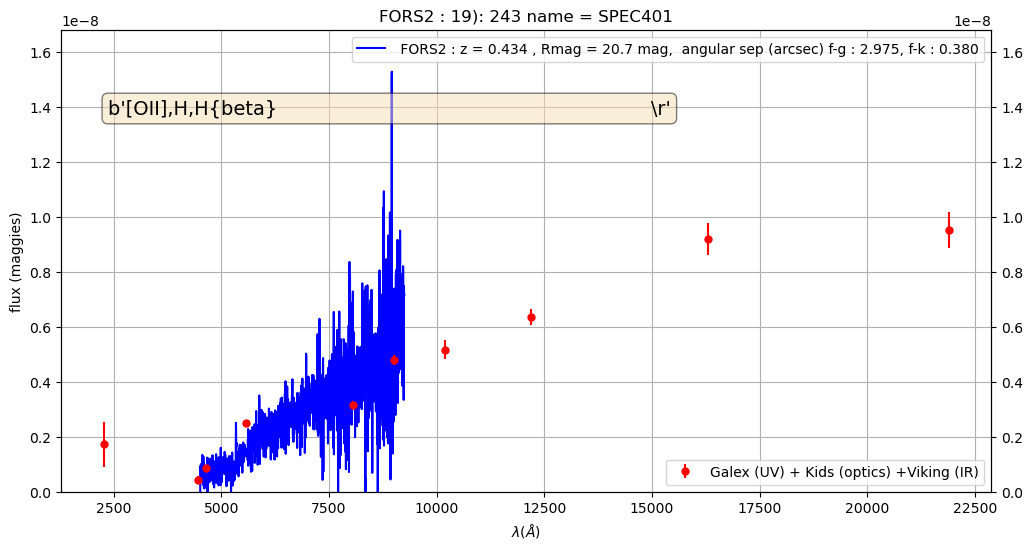

20  ==  SPEC402 402 244
b'[OII],H9,K,H,H{delta}                                                       \r'
2.8774305760391722e-08 3.943248865234637e-08 4.3375737517581014e-08


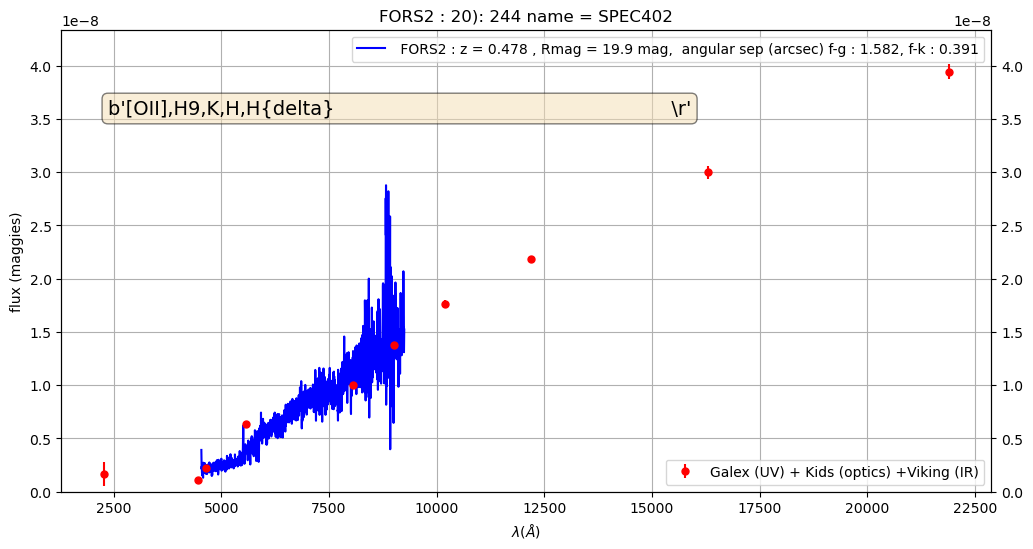

21  ==  SPEC403 403 245
b'[OII],H,H{alpha}                                                            \r'
1.0686760206648495e-08 3.7134117032356704e-09 1.1755436227313345e-08


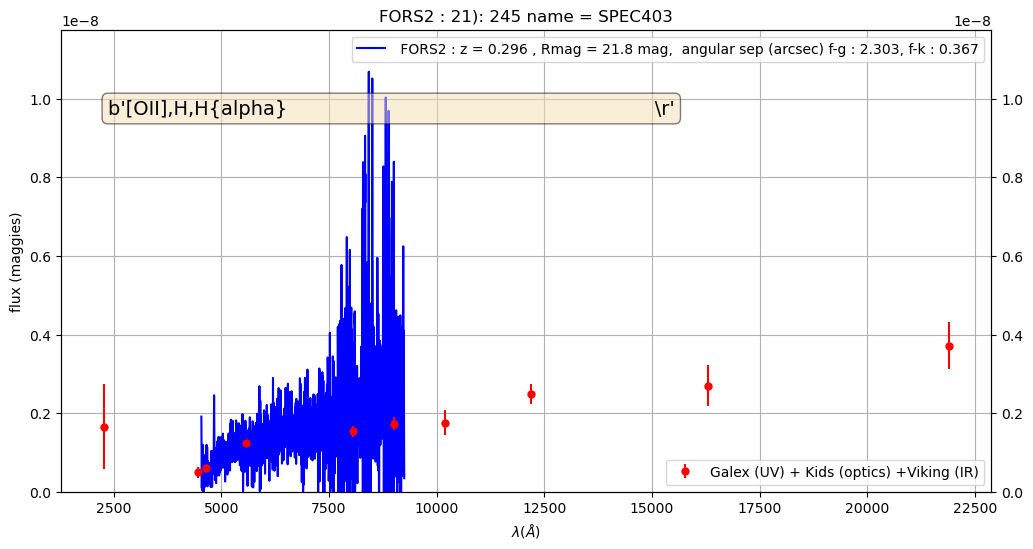

22  ==  SPEC411 411 253
b'[OII],H8,K,H,H{delta}                                                       \r'
7.55698887470527e-09 1.0706996570632723e-08 1.1777696227695996e-08


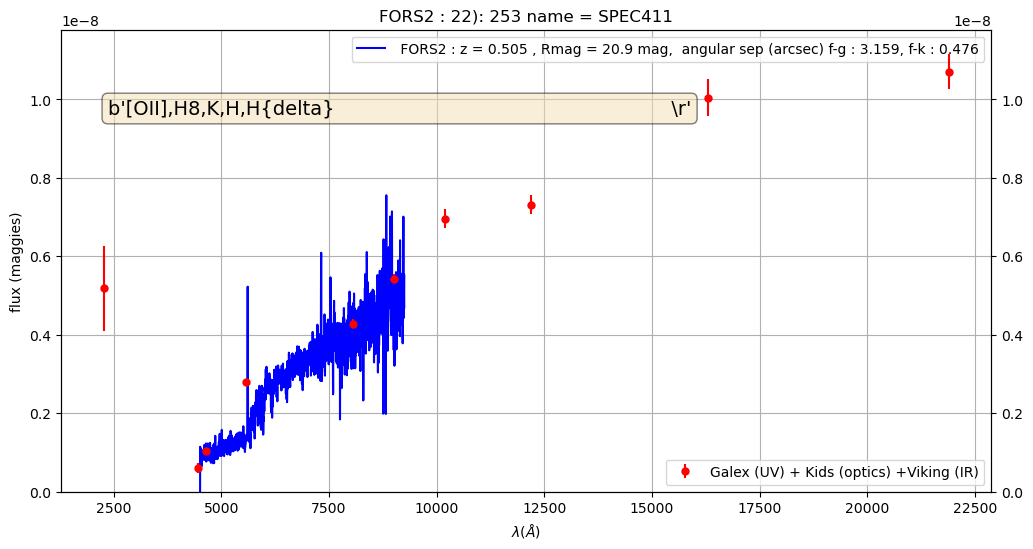

23  ==  SPEC414 414 256
b'MgII,[OII],H10,H9,H8,H,H{delta}                                             \r'
8.5688959084687e-09 1.506061519997437e-08 1.6566676719971806e-08


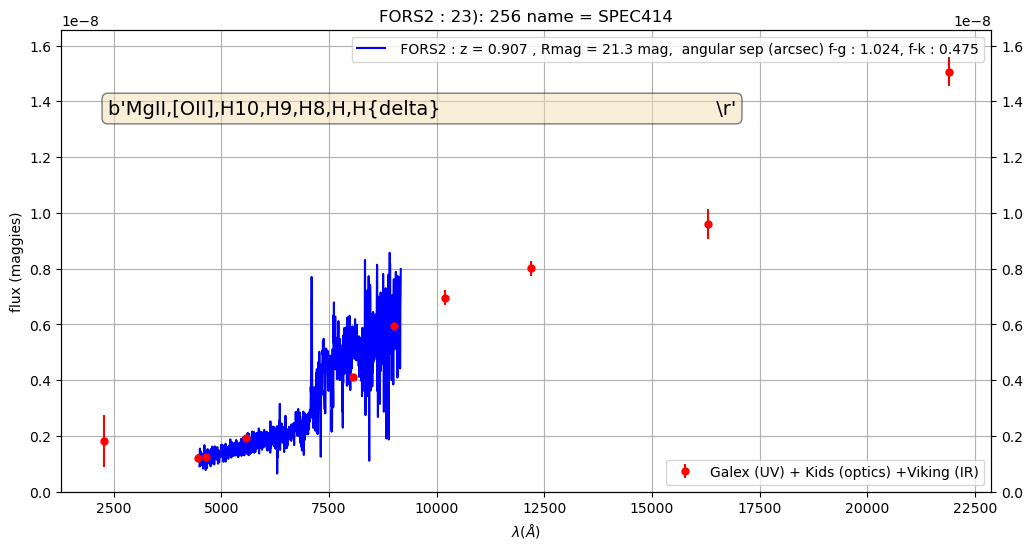

24  ==  SPEC415 415 257
b'[OIII],H{alpha}                                                             \r'
1.8234497449441667e-08 6.5050171158327595e-09 2.0057947194385836e-08


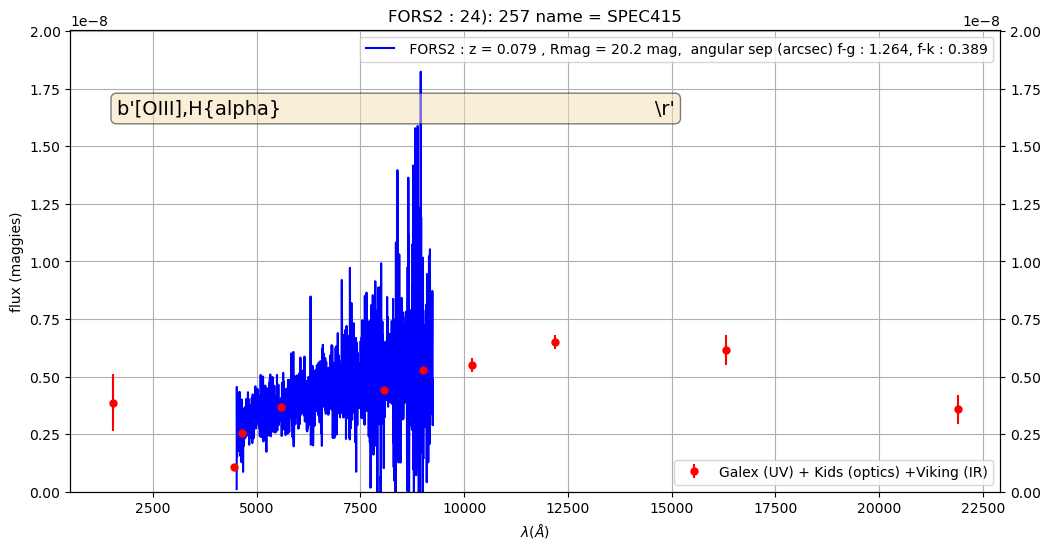

25  ==  SPEC421 421 263
b'H{beta},[OIII],H{alpha}                                                     \r'
2.7319321291974233e-08 1.1377705478542063e-08 3.005125342117166e-08


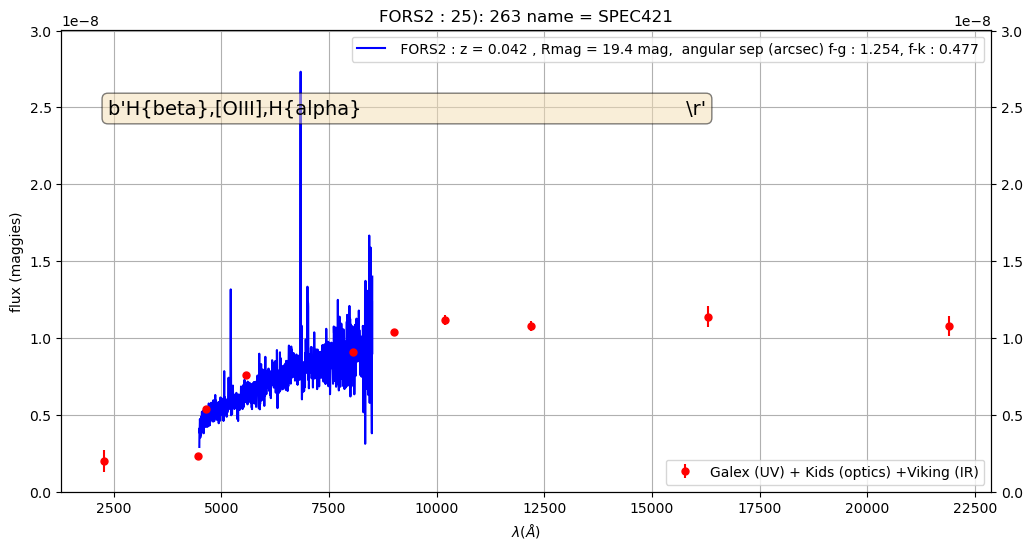

26  ==  SPEC434 434 275
b'[OII],H{beta},[OIII],H{alpha}                                               \r'
2.1024516138733163e-08 2.228620873488908e-09 2.312696775260648e-08


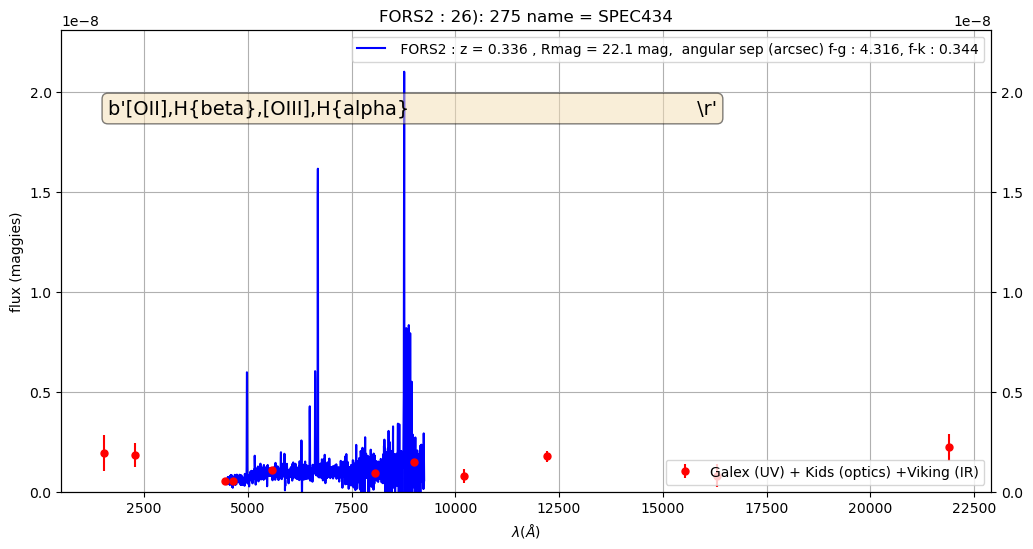

27  ==  SPEC435 435 276
b'[OII],K,H,H{beta},[OIII],H{alpha}                                           \r'
1.0853497645815891e-07 6.041637063796062e-08 1.193884741039748e-07


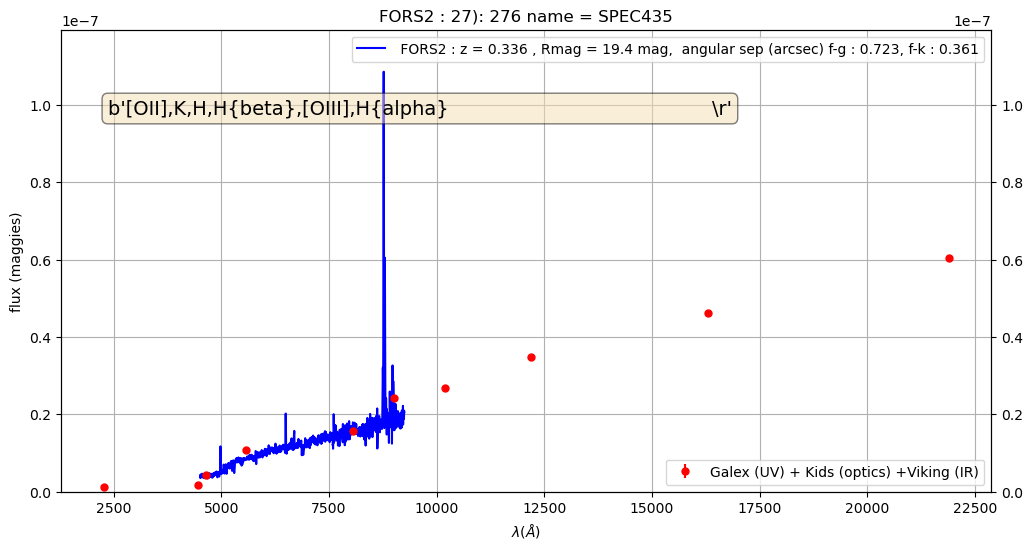

28  ==  SPEC437 437 278
b'[OII],H{beta},[OIII],H{alpha}                                               \r'
3.50285125515752e-08 9.695545875810941e-09 3.8531363806732724e-08


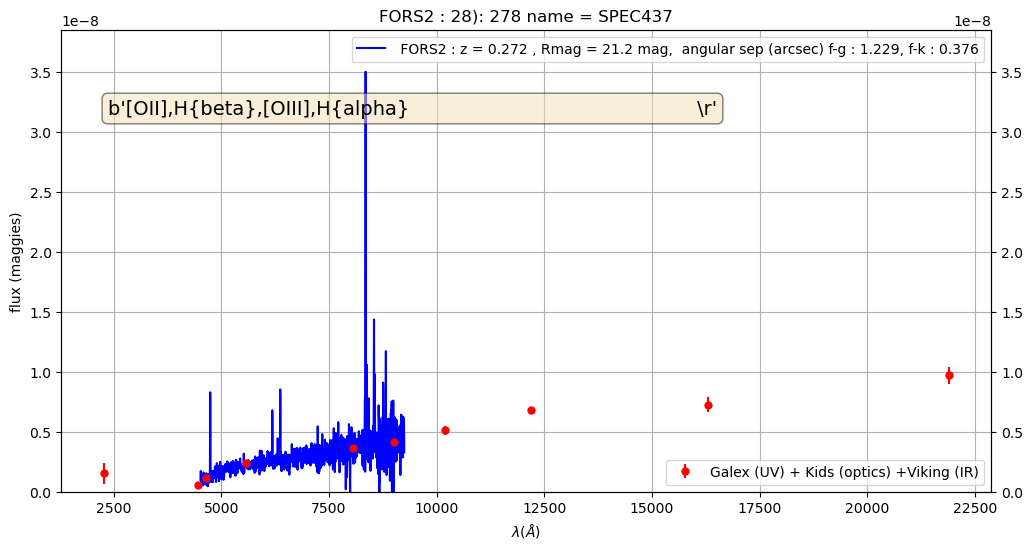

29  ==  SPEC444 444 285
b'[OII],K,H,H{beta}                                                           \r'
6.0172279598146585e-09 7.955278076354869e-09 8.750805883990355e-09


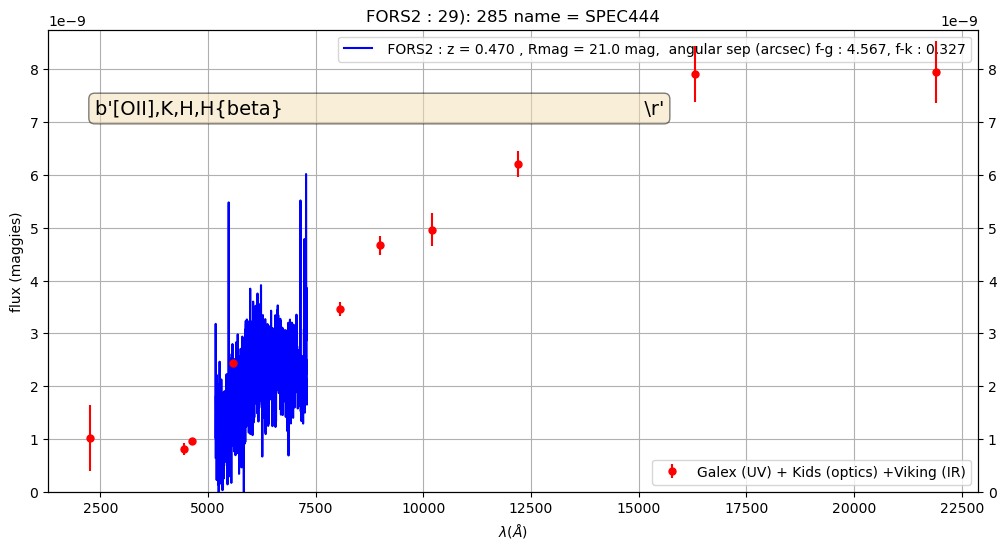

30  ==  SPEC451 451 292
b'K,H,4000{AA}-break,H{delta}                                                 \r'
1.2631102003278847e-08 1.8734188585719294e-08 2.0607607444291226e-08


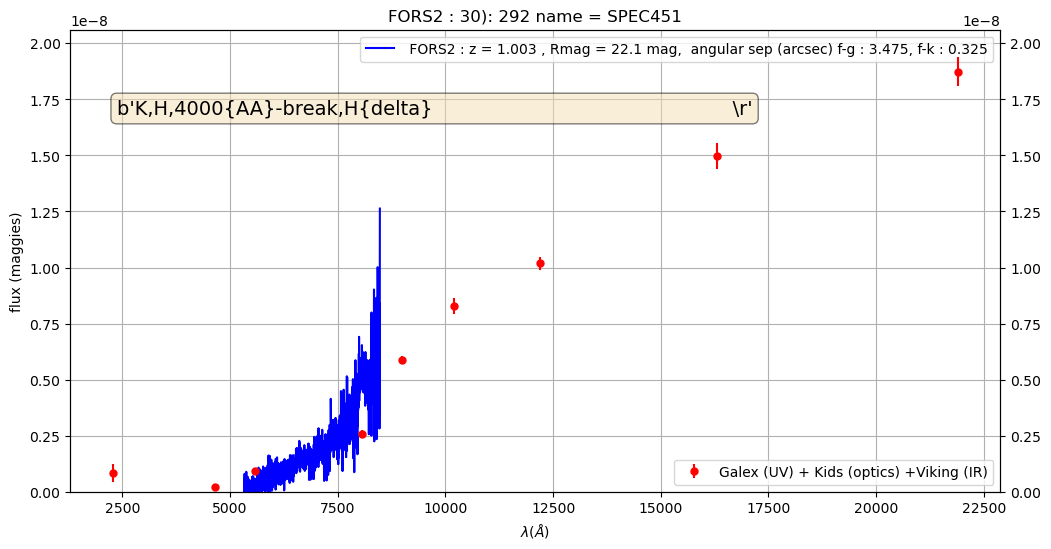

31  ==  SPEC471 471 312
b'[OII],H{beta},[OIII]                                                        \r'
2.638392984674289e-08 5.302320099067493e-09 2.902232283141718e-08


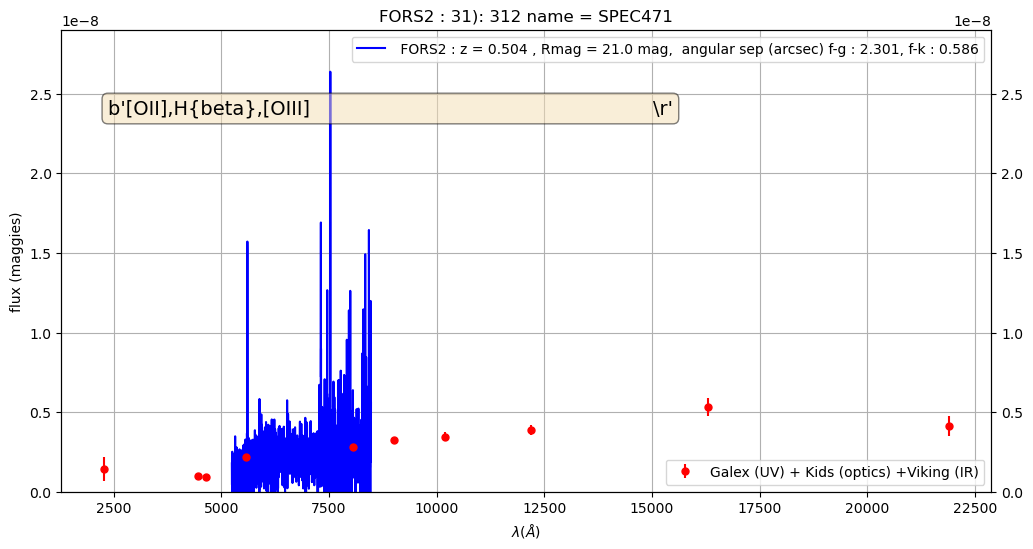

32  ==  SPEC472 472 313
b'[OII],H{beta},[OIII]                                                        \r'
1.0761613588695326e-08 4.34015600758661e-09 1.183777494756486e-08


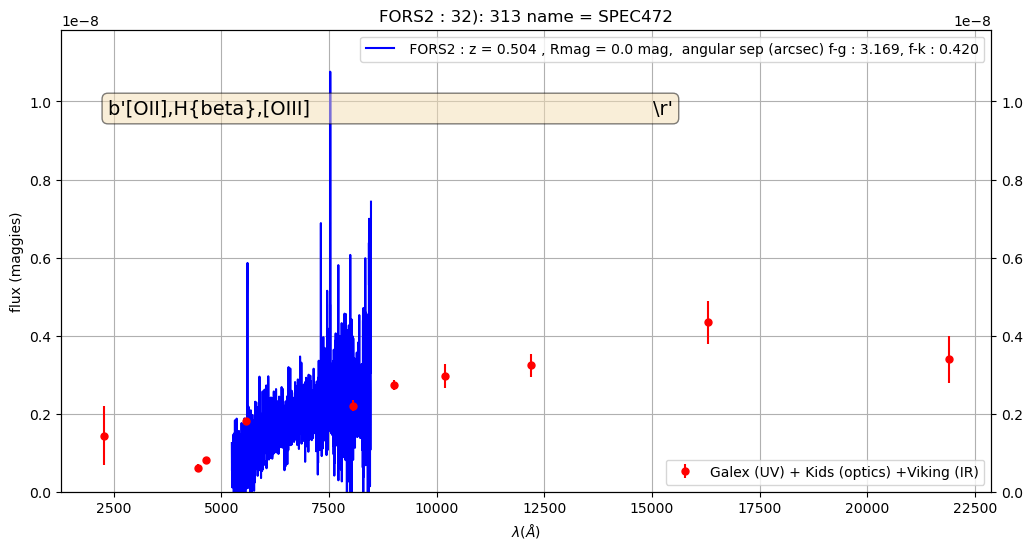

33  ==  SPEC476 476 316
b'[OIII],H{alpha}                                                             \r'
3.167713211850045e-07 4.8438233169530956e-08 3.48448453303505e-07


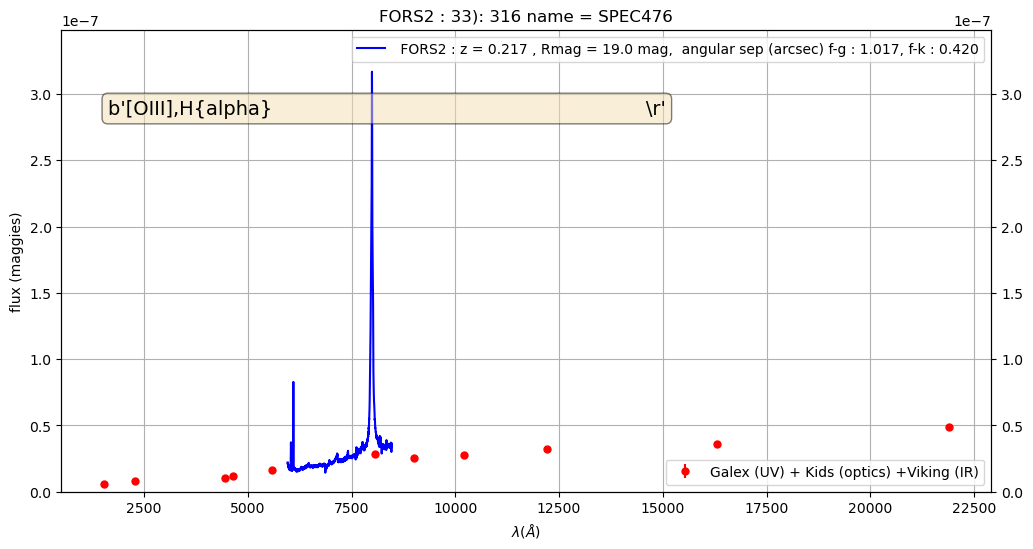

34  ==  SPEC499 499 331
b'[OII],H{beta},[OIII]                                                        \r'
2.0201095537211774e-08 1.4235532535482342e-08 2.2221205090932954e-08


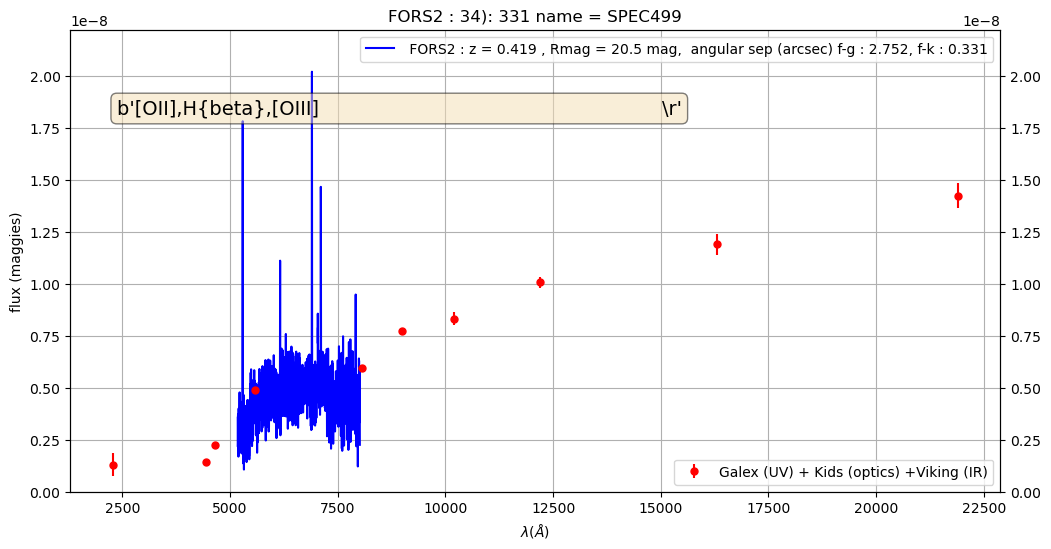

35  ==  SPEC516 516 345
b'                                                                            \r'
5.0949728624805055e-08 3.7320108836807077e-08 5.6044701487285565e-08


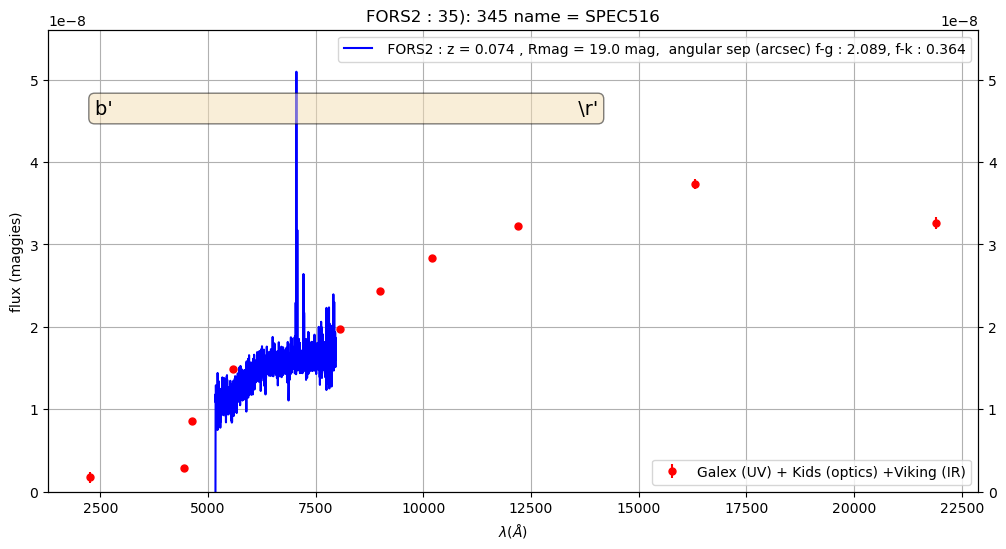

36  ==  SPEC519 519 348
b'K,H,G,Fe43,Fe45,H{beta},Mgb                                                 \r'
7.086340106607658e-08 1.3232791166902713e-07 1.4556070283592985e-07


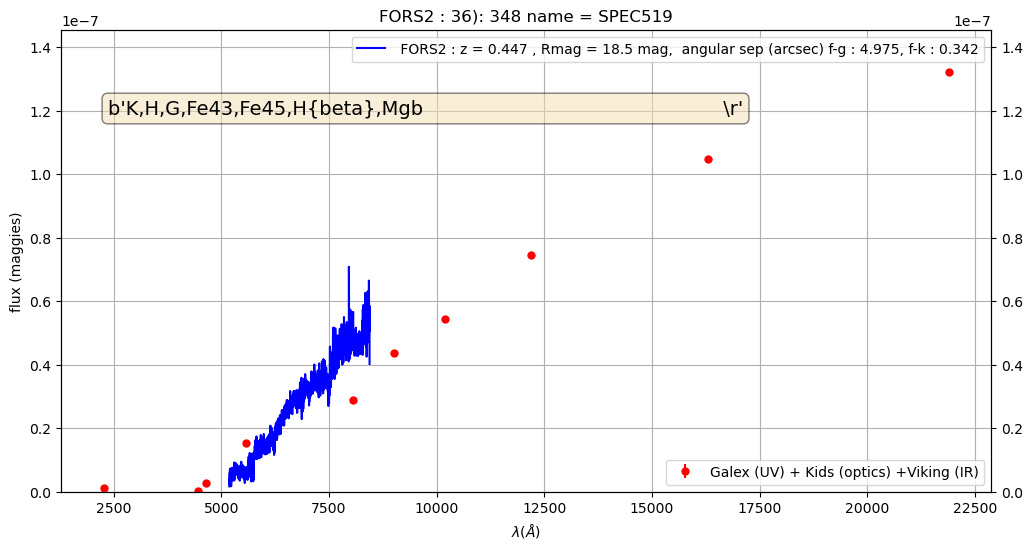

37  ==  SPEC558 558 382
b'[OII],H9,K,H,H{beta},[OIII]                                                 \r'
1.5149693624200894e-08 7.784336477137572e-09 1.6664662986620985e-08


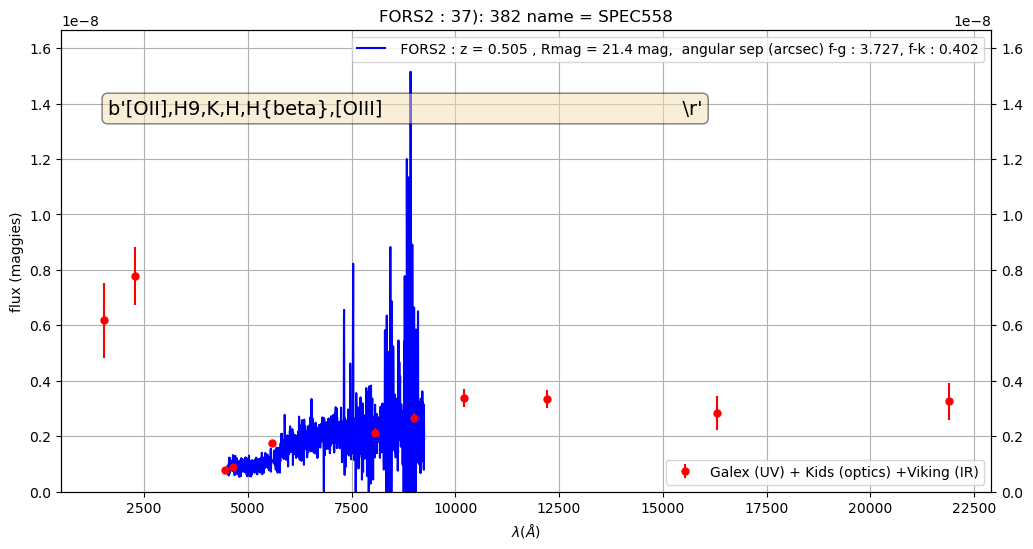

38  ==  SPEC560 560 384
b'G,H{beta},Mgb,NaD                                                           \r'
2.3937147883051905e-07 3.689482753878006e-07 4.058431029265807e-07


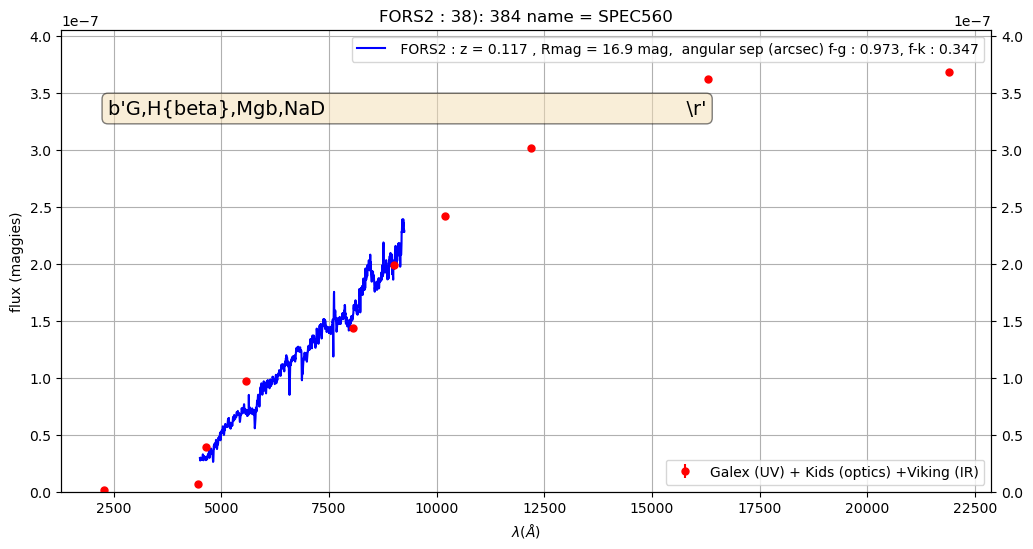

39  ==  SPEC563 563 386
b'H{delta},G,Mgb,NaD,H{alpha}                                                 \r'
1.4847808098807345e-07 1.6289450455666116e-07 1.791839550123273e-07


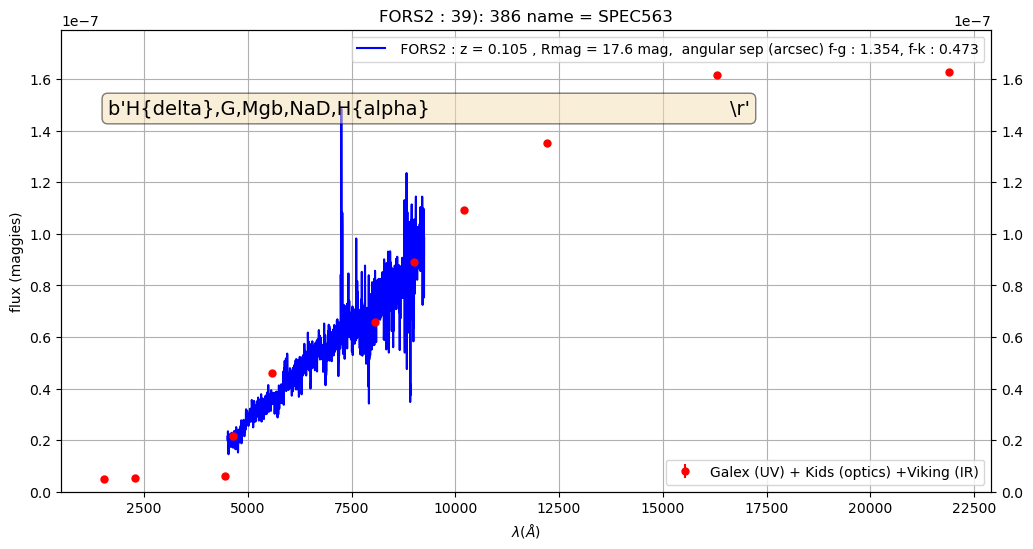

40  ==  SPEC564 564 387
b'[OII],H{delta},H{gamma},H{beta},[OIII],H{alpha}                             \r'
9.593877188826963e-08 7.496531704833389e-09 1.055326490770966e-07


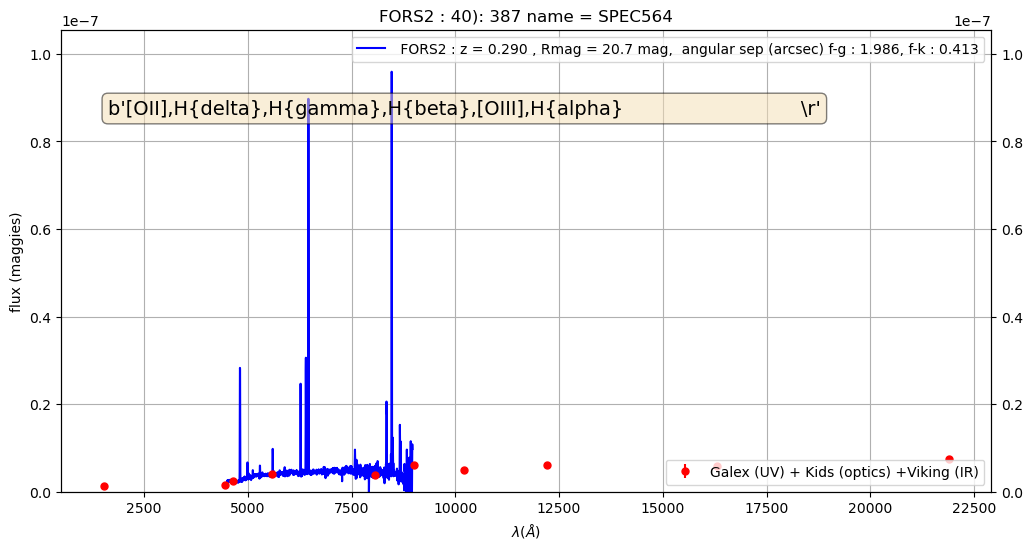

41  ==  SPEC572 572 395
b'[OII],H10,H9,H8,K,H,H{beta},[OIII],H{alpha}                                 \r'
1.0250989330962448e-07 3.2340316266260716e-08 1.1276088264058694e-07


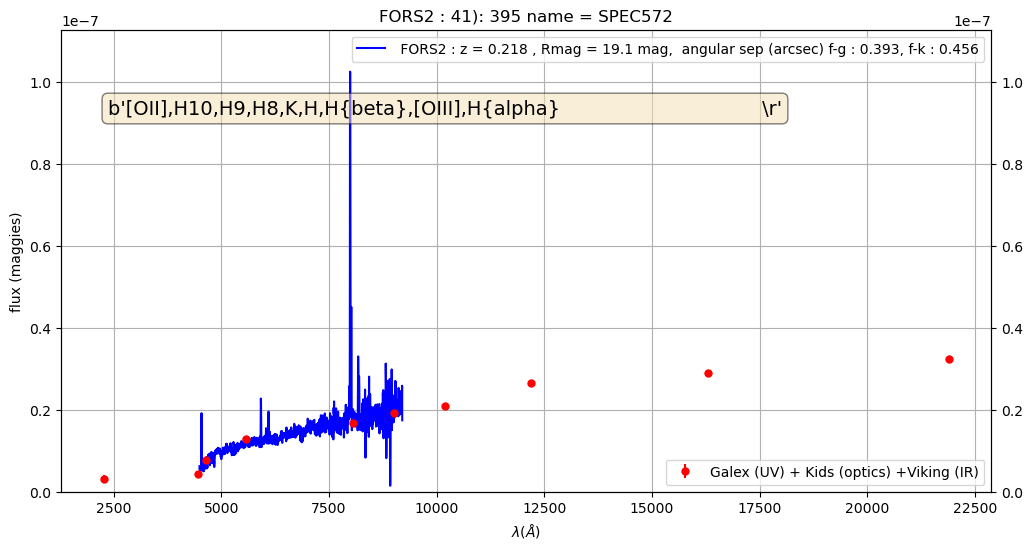

42  ==  SPEC587 587 409
b'[OII],H9,H,H{beta},[OIII]                                                   \r'
6.772694419464925e-09 4.594266529382425e-09 7.449963861411419e-09


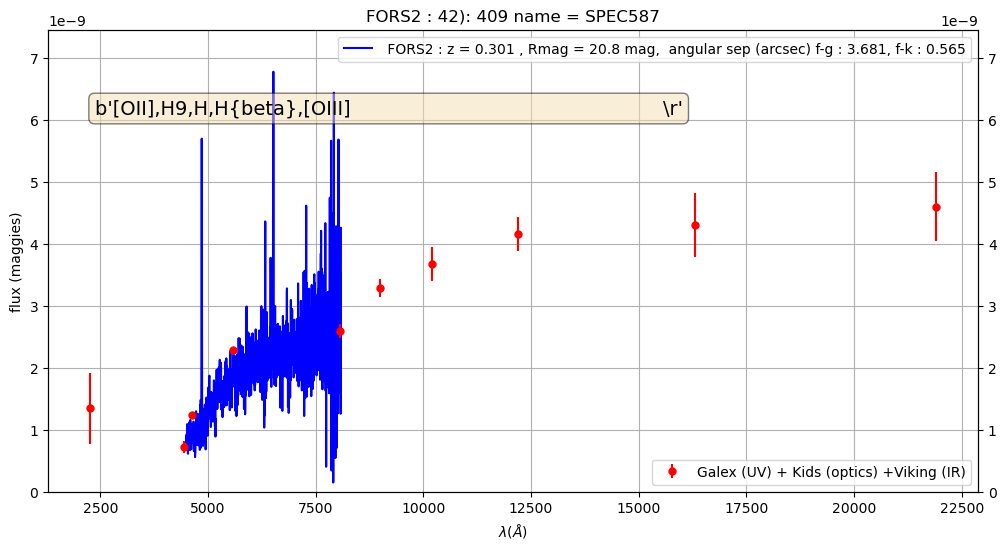

43  ==  SPEC589 589 411
b'[OII],H9,H,H{delta}                                                         \r'
9.128030007642008e-09 2.1611871806963968e-08 2.3773058987660367e-08


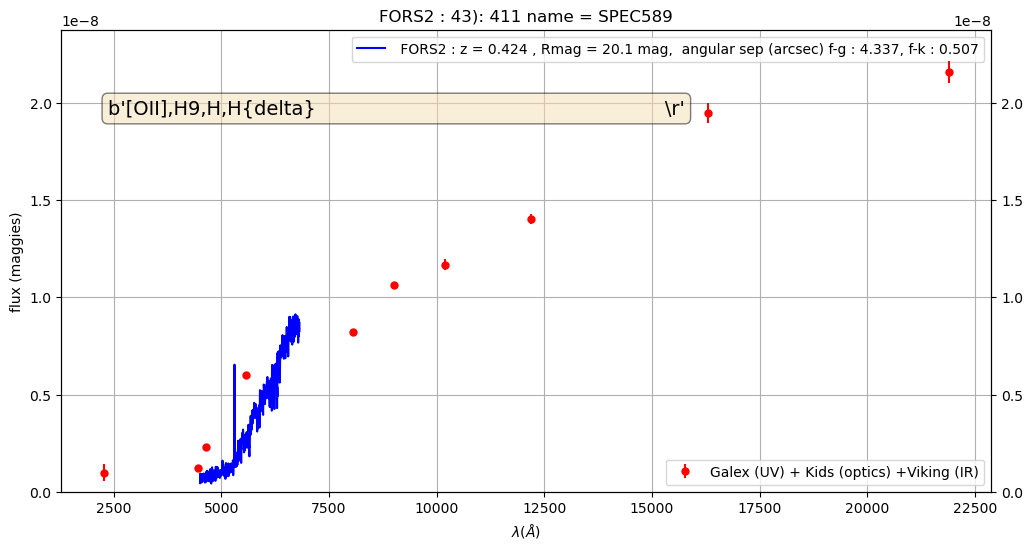

44  ==  SPEC591 591 413
b'broad,MgII,[OII],(QSO)                                                      \r'
7.356473818508949e-09 1.0299873210674007e-08 1.1329860531741408e-08


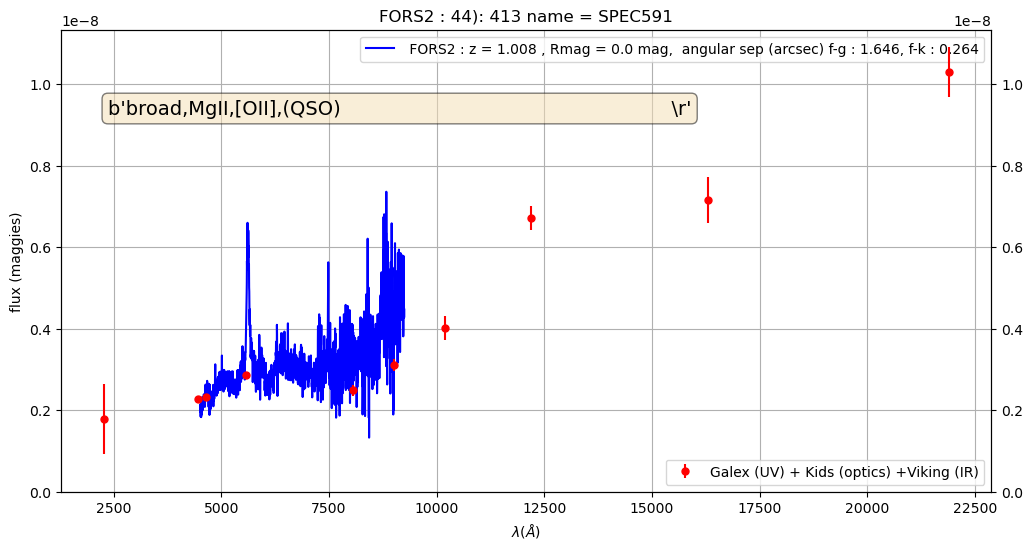

45  ==  SPEC595 595 416
b'[OII],H11,H10,H9,H8,K,H,H{delta},H{beta},[OIII]                             \r'
3.687942803243347e-08 1.4260612648599887e-08 4.056737083567682e-08


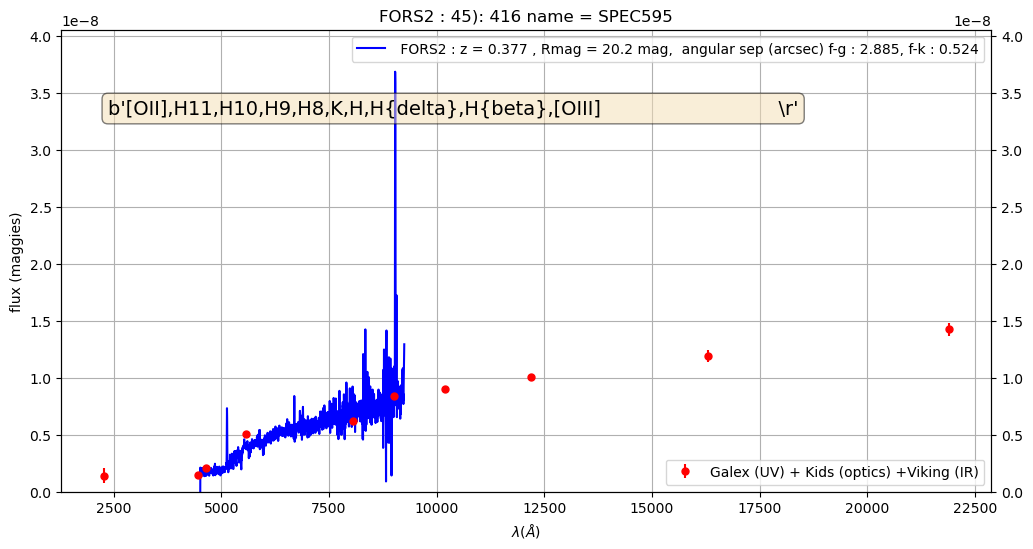

46  ==  SPEC604 604 425
b'H{beta},[OIII],H{alpha}                                                     \r'
1.756735967801377e-08 3.334243275311327e-09 1.9324095645815147e-08


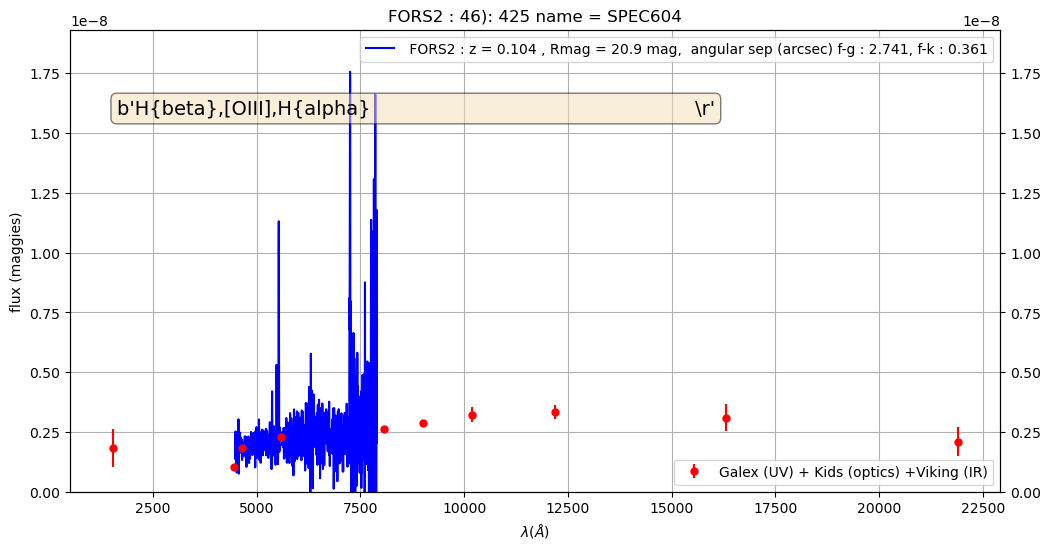

47  ==  SPEC608 608 428
b'weak,[OII],K,H,4000{AA}-break                                               \r'
1.530846613964501e-08 7.811940767038363e-09 1.683931275360951e-08


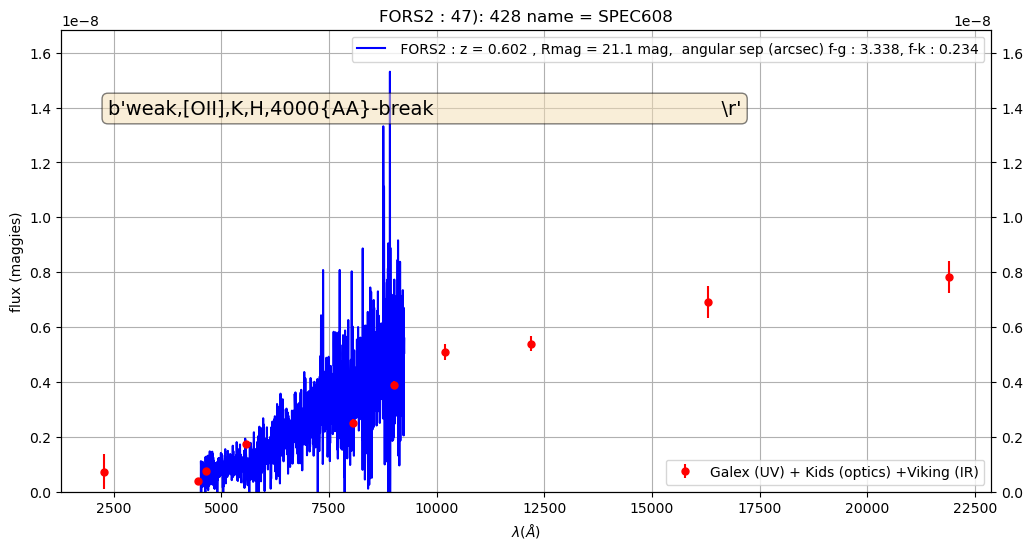

48  ==  SPEC611 611 431
b'[OII],H8,K,H,H{delta}                                                       \r'
1.899018635098281e-08 1.0987596692643429e-08 2.088920498608109e-08


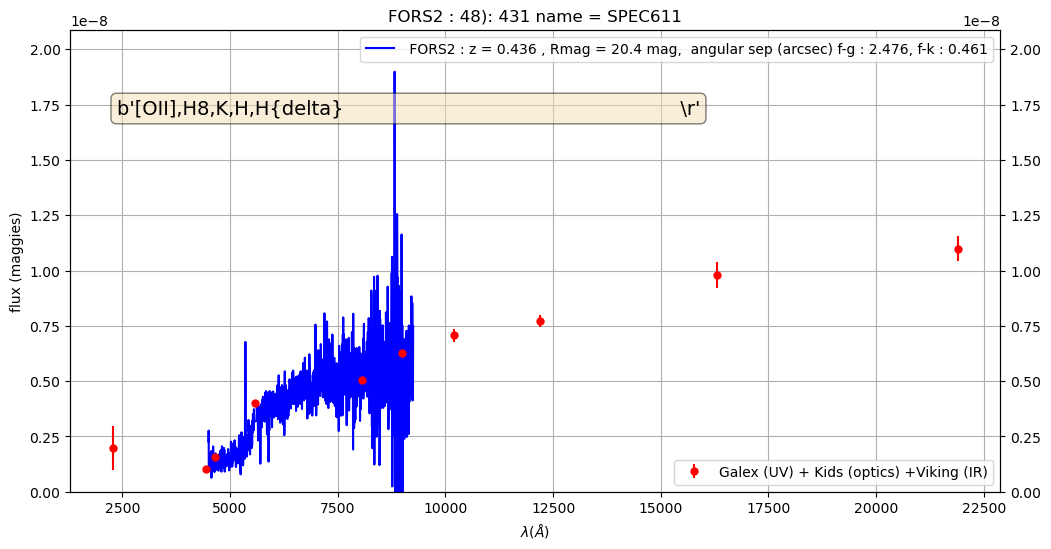

49  ==  SPEC626 626 442
b'[OII],H8,K,H                                                                \r'
1.1702825538322948e-08 8.8889456389204e-09 1.2873108092155244e-08


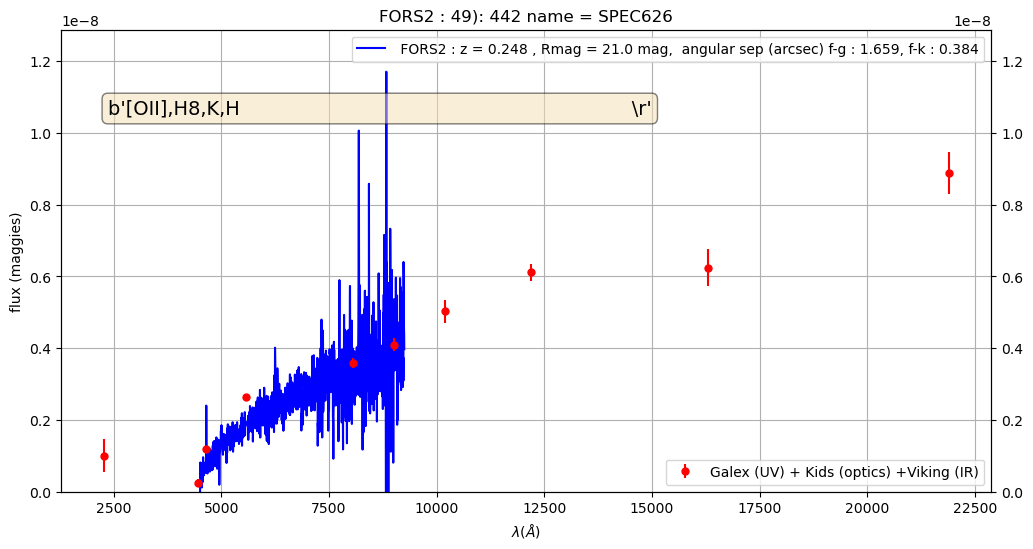

50  ==  SPEC642 642 458
b'[OII],H10,H{gamma},H{beta},[OIII]                                           \r'
2.220600570236299e-08 1.8163690852423726e-08 2.442660627259929e-08


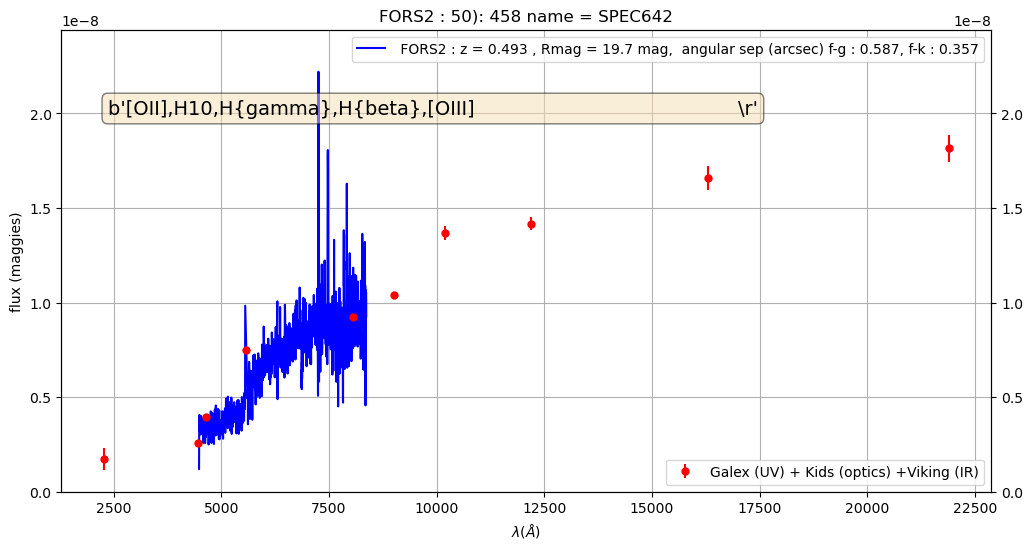

51  ==  SPEC643 643 459
b'H8,K,H,4000{AA}-break                                                       \r'
4.965871698050383e-08 7.003666697790432e-08 7.704033367569475e-08


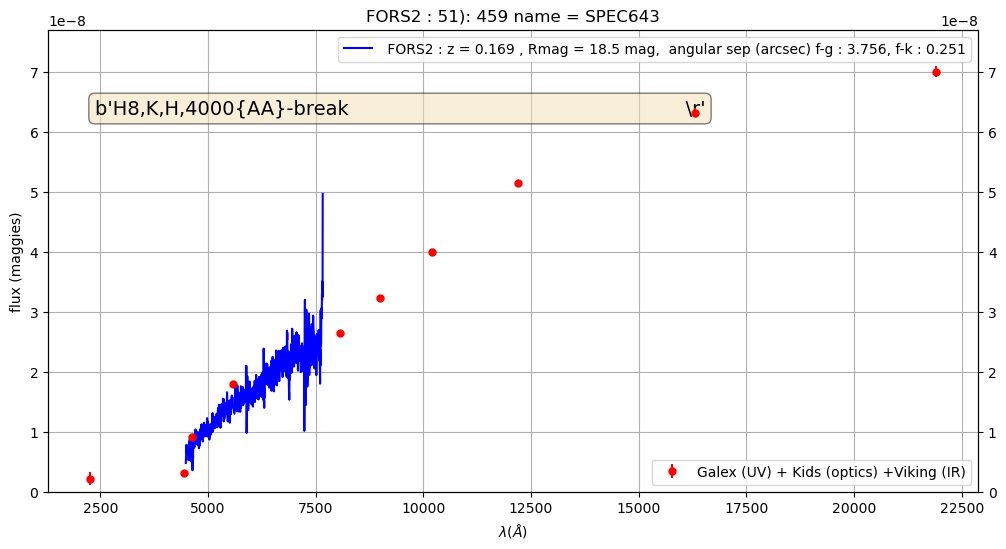

52  ==  SPEC645 645 461
b'H{beta},[OIII],H{alpha}                                                     \r'
2.9151839866145994e-08 1.1797301653133407e-08 3.206702385276059e-08


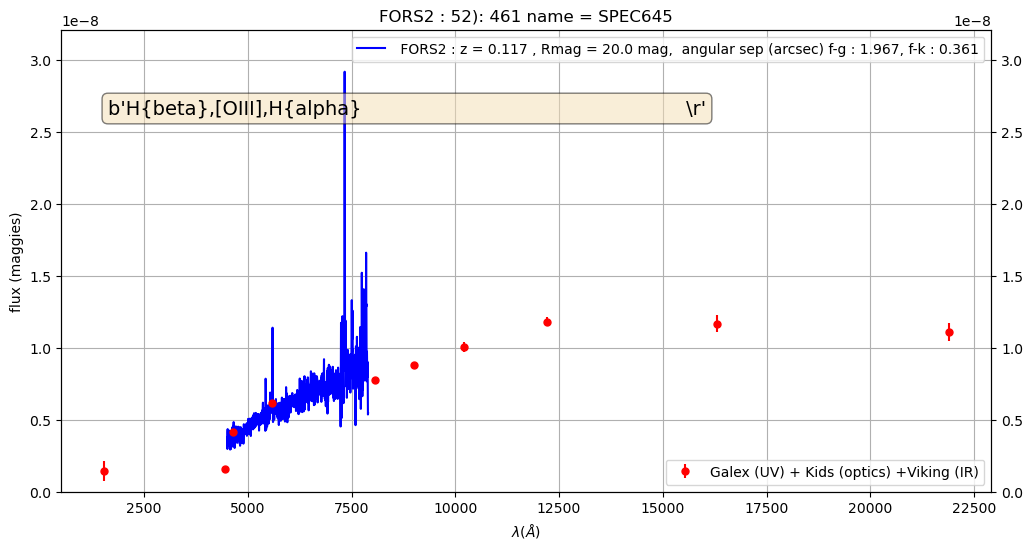

53  ==  SPEC647 647 463
b'H{beta},[OIII],H{alpha}                                                     \r'
2.6944930241312492e-08 8.259955196802679e-09 2.9639423265443745e-08


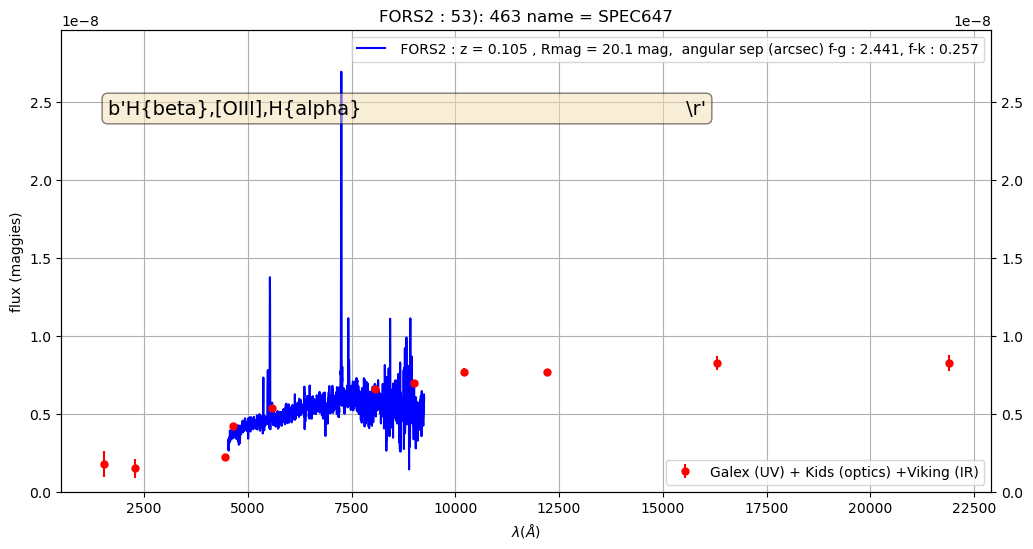

54  ==  SPEC653 653 469
b'[OII],H9,H8,K,H,H{beta},H{alpha}                                            \r'
5.936958714681953e-08 1.3861974760479098e-08 6.530654586150148e-08


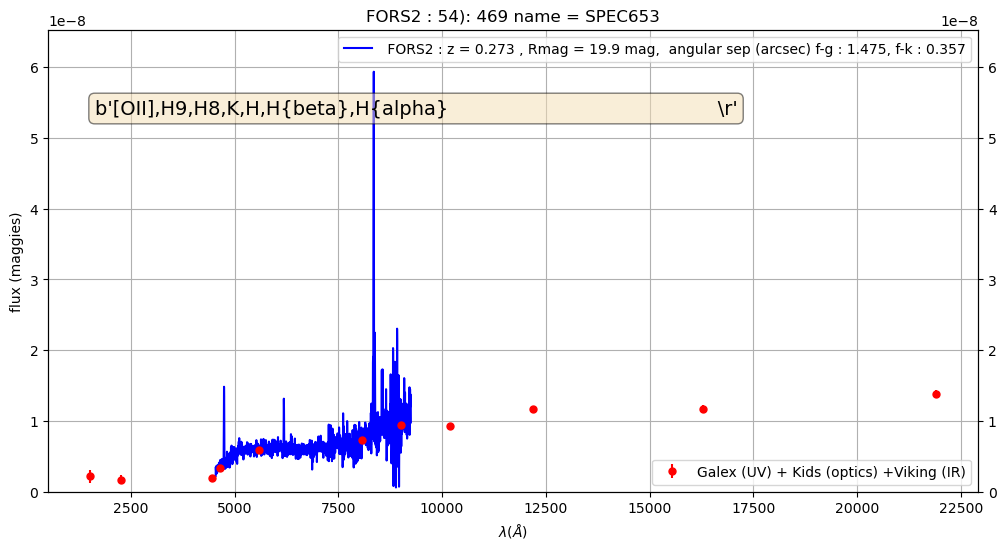

55  ==  SPEC657 657 473
b'H{beta},[OIII],H{alpha}                                                     \r'
3.788301957131749e-08 4.587266326928963e-09 4.167132152844924e-08


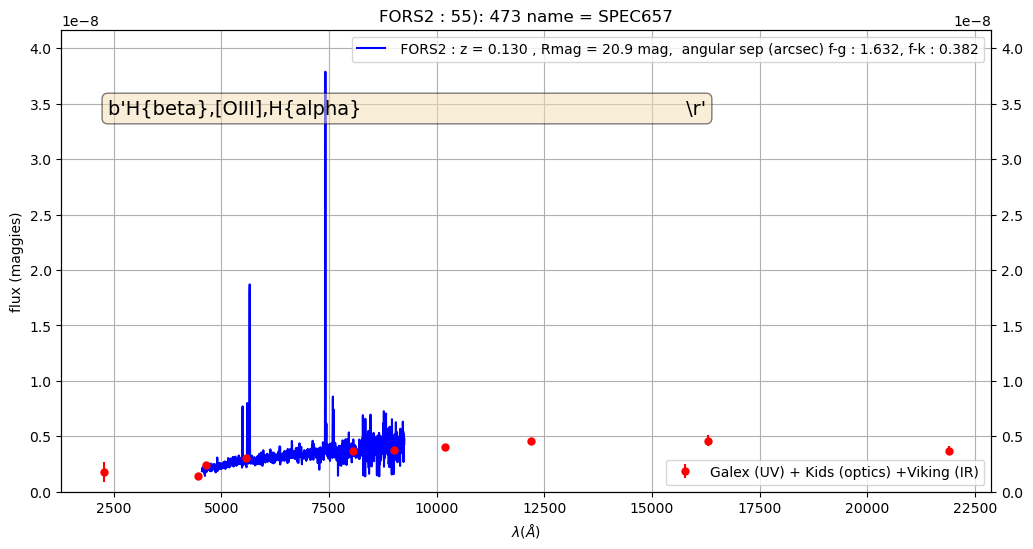

56  ==  SPEC664 664 480
b'[OII],H8,K,H,H{delta},H{beta},[OIII]                                        \r'
1.1553896949156562e-08 9.970512878244049e-09 1.270928664407222e-08


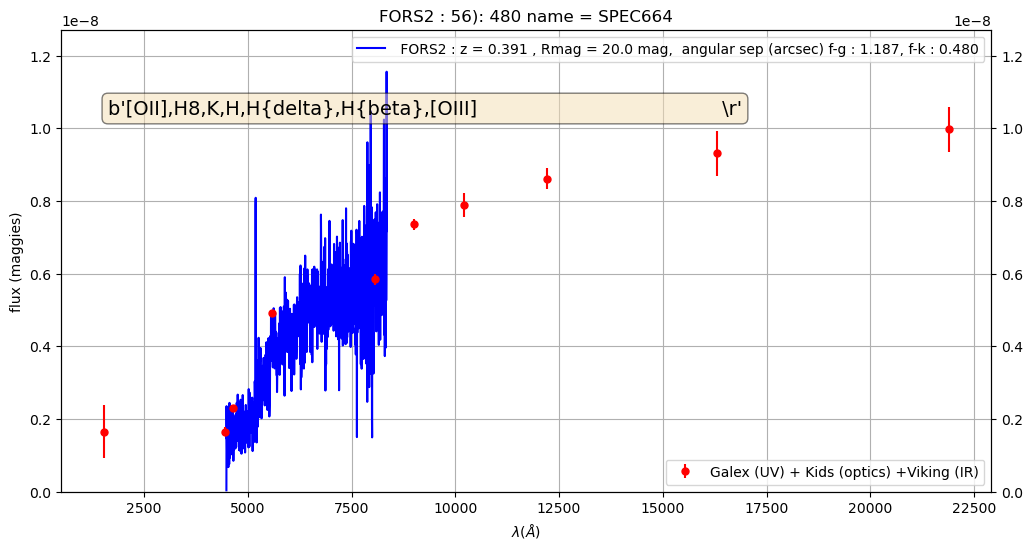

57  ==  SPEC669 669 483
b'[OII],H9,H8,K,H,H{delta}                                                    \r'
1.8293688643516266e-08 1.4250920785062188e-08 2.0123057507867895e-08


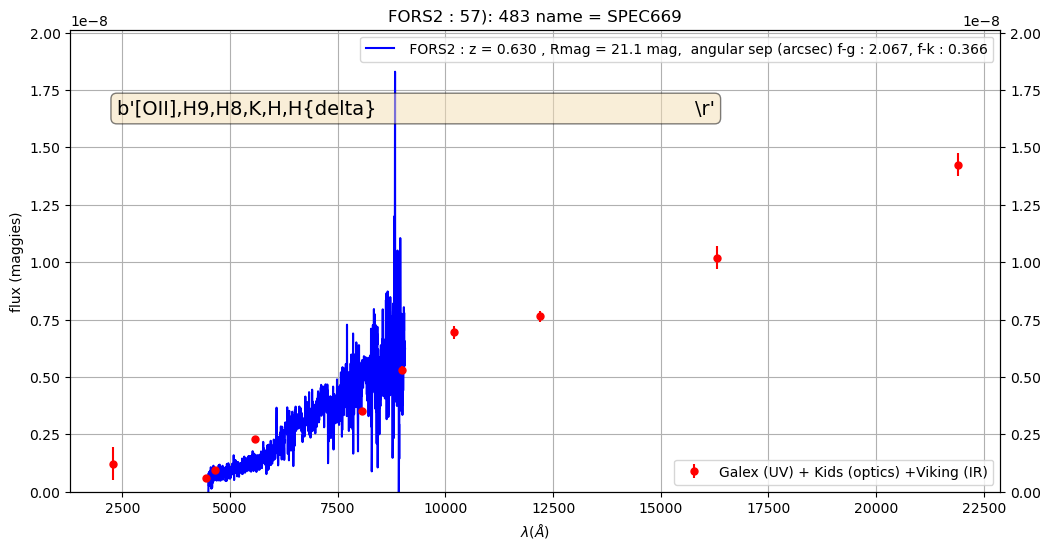

58  ==  SPEC691 691 504
b'[OIII],H{alpha}                                                             \r'
1.0349900620496918e-08 2.881149107837282e-09 1.138489068254661e-08


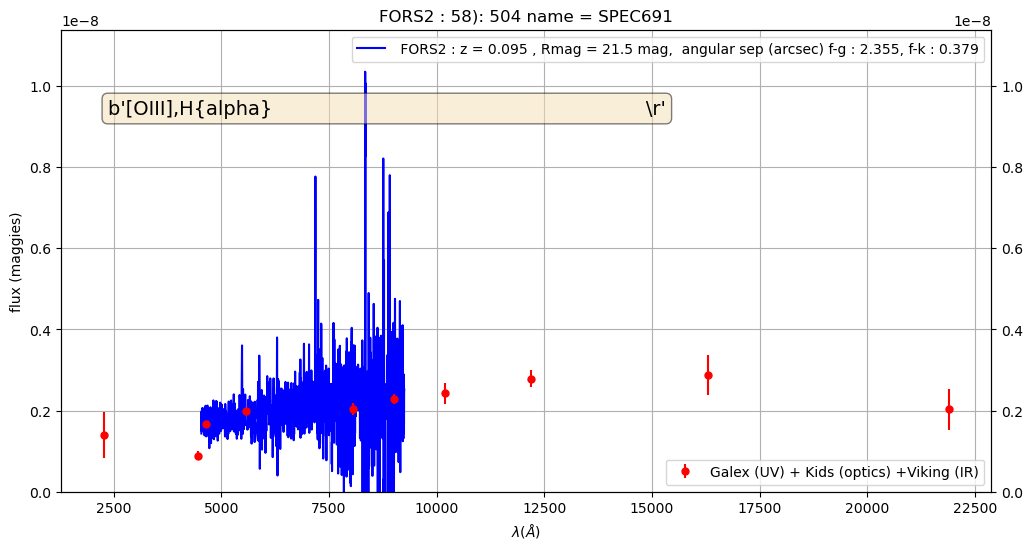

59  ==  SPEC698 698 511
b'H{beta},[OIII],H{alpha}                                                     \r'
2.7039140176861968e-08 2.1427237655661753e-09 2.9743054194548166e-08


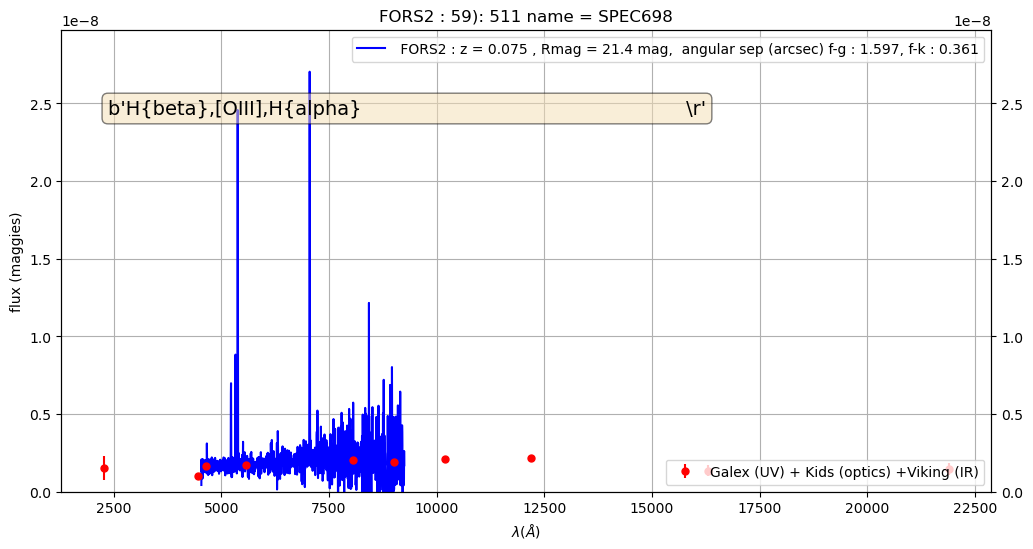

60  ==  SPEC699 699 512
b'H9,H8,K,H,H{delta},H{beta}                                                  \r'
7.575291873366682e-09 1.555049550940416e-08 1.7105545060344578e-08


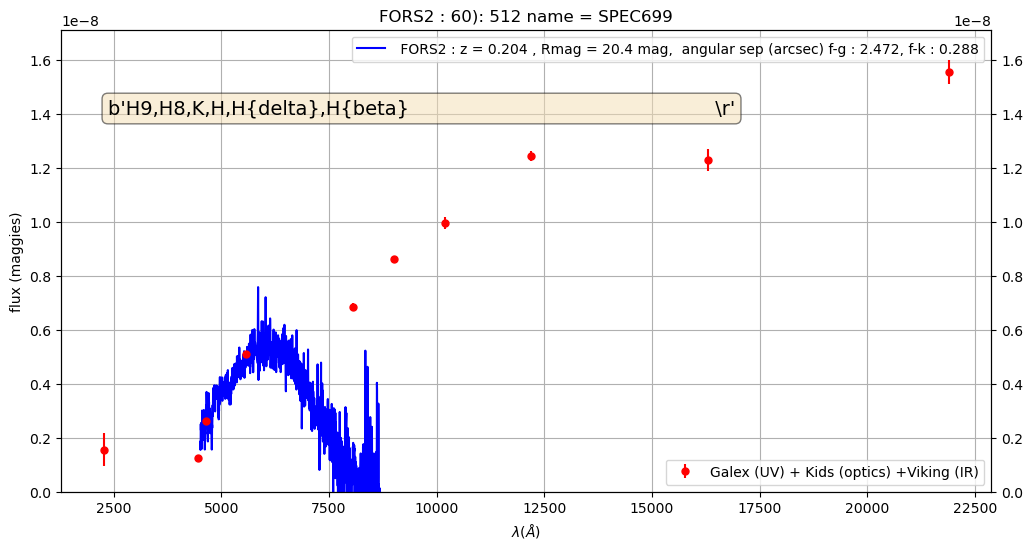

61  ==  SPEC717 717 528
b'[OII]                                                                       \r'
6.743606778465641e-09 2.498968447714463e-09 7.4179674563122055e-09


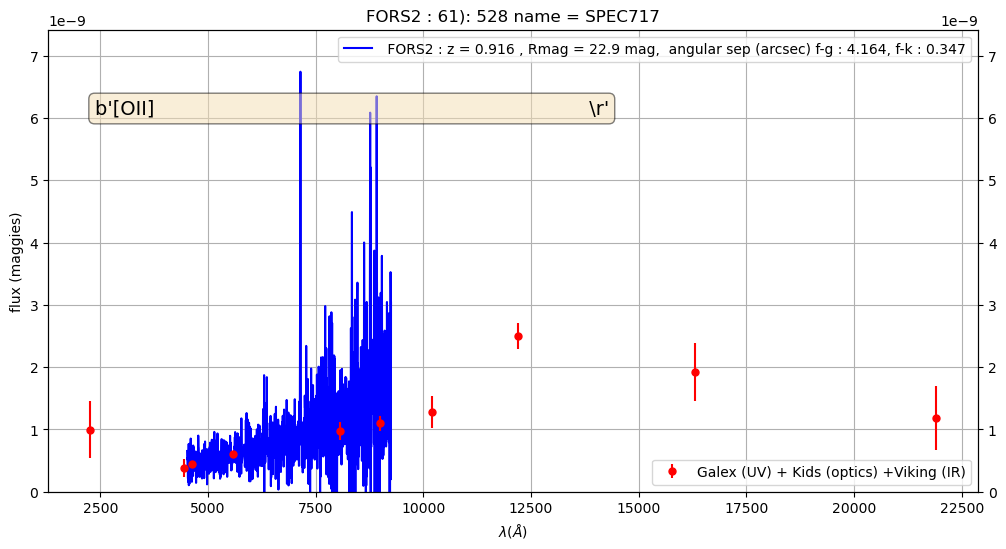

62  ==  SPEC719 719 530
b'[OII],H11,H10,H9,H8,K,H,H{delta},H{beta},[OIII],H{alpha}                    \r'
6.252187858554612e-08 1.542997325660118e-08 6.877406644410074e-08


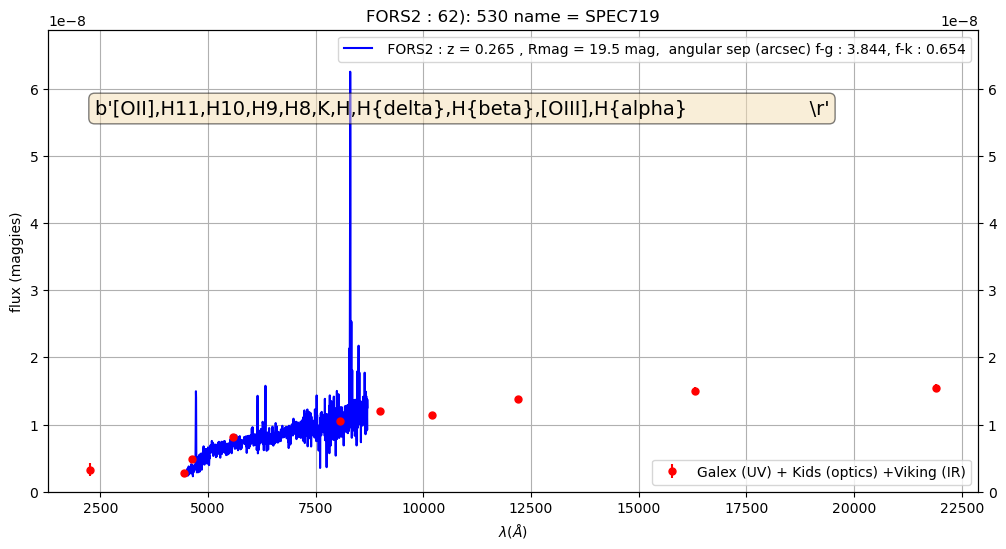

63  ==  SPEC722 722 533
b'broad,MgII,(QSO)                                                            \r'
2.8781375666565387e-09 4.038210603731779e-09 4.442031664104957e-09


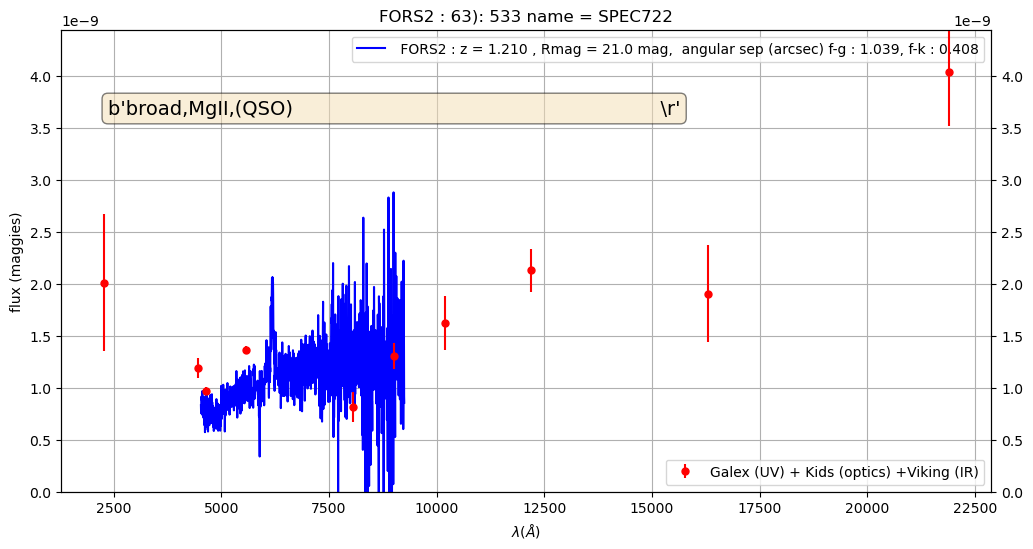

64  ==  SPEC724 724 535
b'[OII],H8,H,H{beta},[OIII],H{alpha}                                          \r'
1.680909637727348e-08 4.474320412232655e-09 1.849000601500083e-08


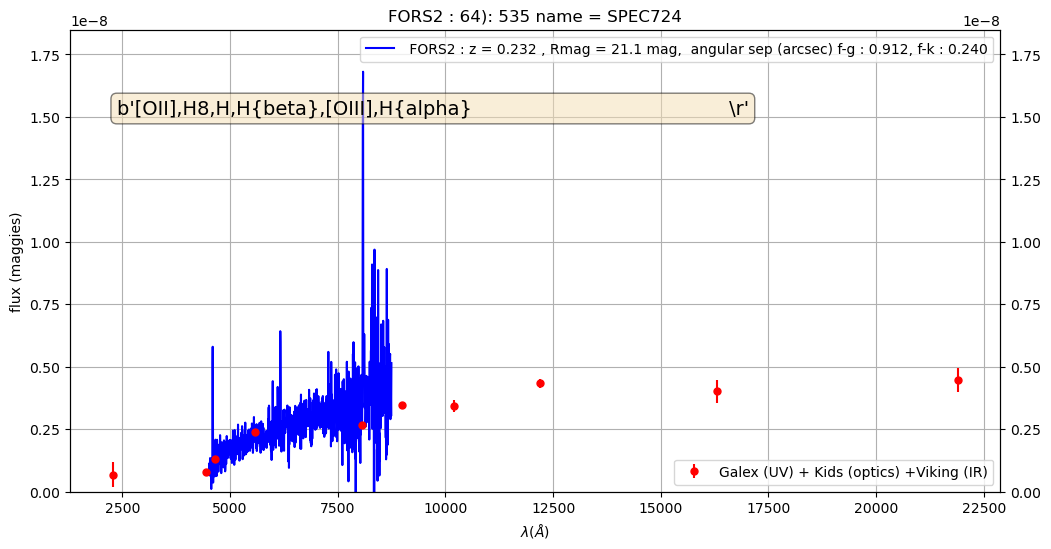

65  ==  SPEC725 725 536
b'[OII],H{beta},[OIII],H{alpha}                                               \r'
1.8798691117592875e-08 5.117695026435406e-09 2.0678560229352165e-08


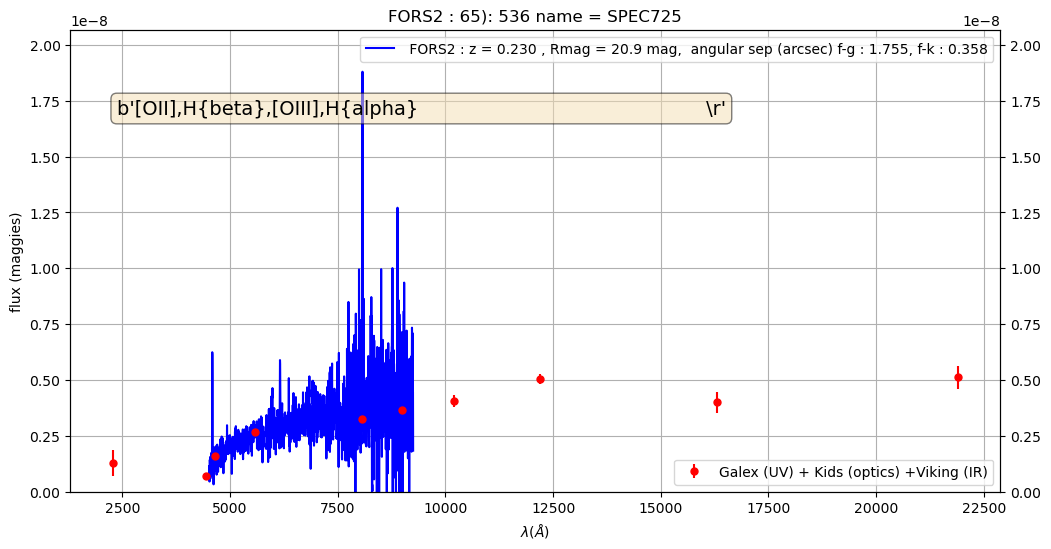

66  ==  SPEC727 727 538
b'[OII],[OIII],H{alpha}                                                       \r'
1.2907560366522501e-08 1.6540236596117032e-09 1.4198316403174753e-08


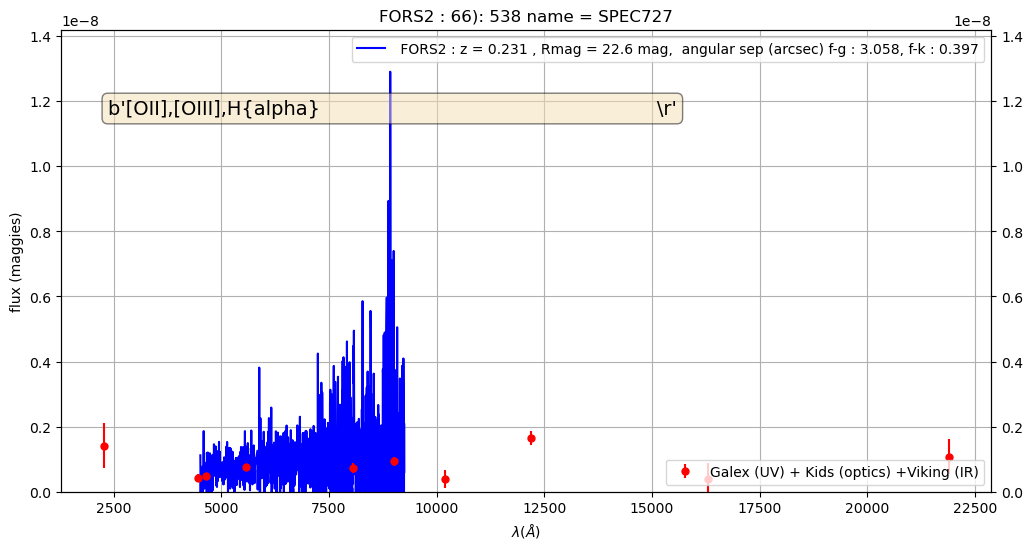

67  ==  SPEC732 732 543
b'H,K,H{gamma},H{beta},[OIII],H{alpha},NII                                    \r'
1.0430022918292572e-07 2.1119228036885273e-08 1.147302521012183e-07


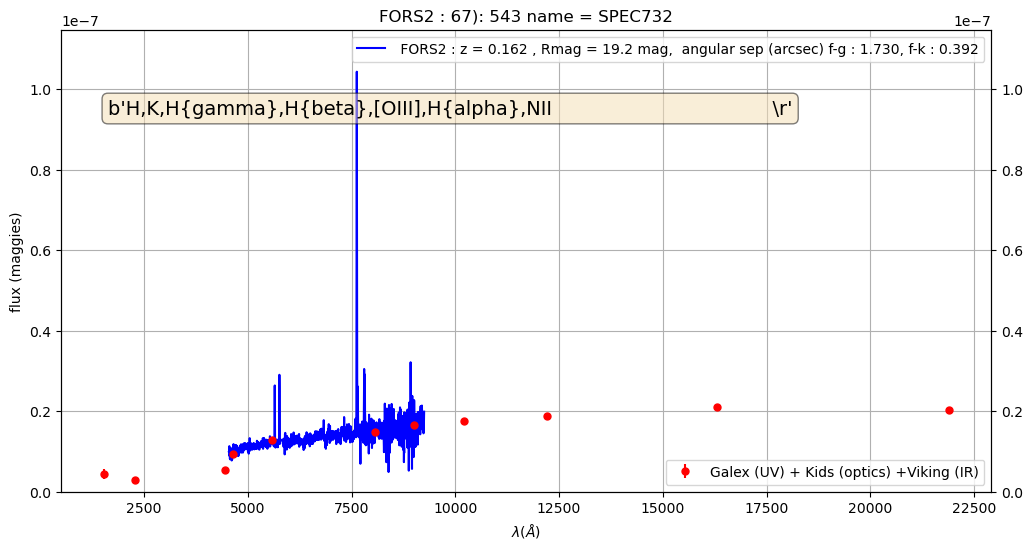

In [36]:
# loop on rows
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for idx,row in df.iterrows():
    print(idx," == ",row["name"],row["num"],row["index0"])
    idx0 = row["index0"] # index for the spectrum
    specname  = row["name"]
    
    mags = [ row["fuv_mag"], row["nuv_mag"], row['MAG_GAAP_u'], row['MAG_GAAP_g'], row['MAG_GAAP_r'], row['MAG_GAAP_i'], row['MAG_GAAP_Z'], row['MAG_GAAP_Y'], 
            row['MAG_GAAP_J'], row['MAG_GAAP_H'],row['MAG_GAAP_Ks'] ]
    
    magserr = [ row["fuv_magerr"], row["nuv_magerr"], row['MAGERR_GAAP_u'], row['MAGERR_GAAP_g'], row['MAGERR_GAAP_r'], row['MAGERR_GAAP_i'], row['MAGERR_GAAP_Z'], row['MAGERR_GAAP_Y'], 
            row['MAGERR_GAAP_J'], row['MAGERR_GAAP_H'],row['MAGERR_GAAP_Ks'] ]
    
    mfluxes = [ 10**(-0.4*m) for m in mags ]
    mfluxeserr = []
    
    for f,em in zip(mfluxes,magserr):
        ferr = 0.4*np.log(10)*em*f
        mfluxeserr.append(ferr)
        
    mfluxes = np.array(mfluxes)
    mfluxeserr = np.array(mfluxeserr)
    
    
    fluxes =  [ row["fuv_flux"], row["nuv_flux"], row['FLUX_GAAP_u'], row['FLUX_GAAP_g'], row['FLUX_GAAP_r'], row['FLUX_GAAP_i'], row['FLUX_GAAP_Z'], row['FLUX_GAAP_Y'], 
            row['FLUX_GAAP_J'], row['FLUX_GAAP_H'],row['FLUX_GAAP_Ks'] ]
    
    fluxeserr =  [ row["fuv_fluxerr"], row["nuv_fluxerr"], row['FLUXERR_GAAP_u'], row['FLUXERR_GAAP_g'], row['FLUXERR_GAAP_r'], row['FLUXERR_GAAP_i'], row['FLUXERR_GAAP_Z'], row['FLUX_GAAP_Y'], 
            row['FLUXERR_GAAP_J'], row['FLUXERR_GAAP_H'],row['FLUXERR_GAAP_Ks'] ]
    
    
    fig = plt.figure(figsize=(12,6))
    ax=fig.add_subplot(1,1,1)
    
    z = row["redshift"]
    asep_fg = row['asep_galex']
    rmag = row["Rmag"]
    asep_fk = row['asep_kids']
    
    print(row["lines"])
    
    
    the_label = f" FORS2 : z = {z:.3f} , Rmag = {rmag:.1f} mag,  angular sep (arcsec) f-g : {asep_fg:.3f}, f-k : {asep_fk:.3f}" 
    
    flambda =  all_df[idx0]["fl"].values
    the_wl =  all_df[idx0]["wl"].values
    
    fnu = ConvertFlambda_to_Fnu(the_wl, flambda)
    fnorm = flux_norm(the_wl,fnu)
    fnu_renorm = fnu/fnorm*10**(-0.4*mags[4])
    
    ax.plot(the_wl, fnu_renorm,'b-',label=the_label)
    #ax.plot(all_df[idx]["wl"], all_df[idx]["fl"],'b-',label=row["num"])
    ax.text(0.05, 0.85, row["lines"], transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
    
    
    ax2 = ax.twinx()
    
    ax2.errorbar(WL,mfluxes,yerr=mfluxeserr,fmt='o',color="r",ecolor="r",ms=5,label='Galex (UV) + Kids (optics) +Viking (IR)')
    #ax2.errorbar(WL, fluxes, yerr=fluxes, xerr=None, fmt='o', color="g",ecolor="g")
    ax2.legend(loc="lower right")
    
    ax.set_xlabel("$\lambda  (\AA)$ ")
    title = f"FORS2 : {idx}): {idx0} name = {specname}"
    ax.set_title(title)
    ax.set_ylabel("flux (maggies)")
    ax.legend(loc="upper right")
    ax.grid()

    goodmags = mfluxes[np.isfinite(mfluxes)]
    
    
    the_max2 = np.max(goodmags)
    the_max1 = np.max(fnu_renorm)
    the_max = 1.1*max(the_max1,the_max2)

    print(the_max1,the_max2,the_max)
    
    ax.set_ylim(0,the_max)
    ax2.set_ylim(0,the_max)
    
    plt.show()